In [67]:
# !pip install --upgrade pip

# # Install PyTorch CUDA 11.8 build
# !pip install --index-url https://download.pytorch.org/whl/cu118 torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2

# # Required for Mamba SSM
# !pip install ninja

# # Install causal-conv1d and Mamba-SSM from HuggingFace wheels
# !pip install causal-conv1d==1.5.2 --no-build-isolation --extra-index-url https://huggingface.github.io/mamba-ssm/whl/cu118/
# !pip install mamba-ssm==2.2.2 --extra-index-url https://huggingface.github.io/mamba-ssm/whl/cu118/


In [68]:
# !pip install -U --no-deps /content/FILENAME.whl
# !pip install -U causal-conv1d==1.5.2  # or the matching wheel if provided

In [69]:
# !mamba install -y python=3.11

In [70]:
import sys, os; print(sys.version, sys.executable)
import sys; print(sys.version, sys.executable)  # 3.11 + /usr/local/bin/python
import torch; print('OK torch', torch.__version__)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0] /usr/bin/python3
3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0] /usr/bin/python3
OK torch 2.9.0+cpu


## 1.Bibliotēku imports

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
# !pip uninstall -y tensorflow
# !pip install tensorflow==2.12.0
# !pip install mamba_ssm

In [73]:
# !pip install patchify nibabel

In [74]:
# %pip -q install condacolab

In [75]:
import sys, os; print(sys.version, sys.executable)
!pip install tensorflow
!pip install nibabel
# %pip install --index-url https://download.pytorch.org/whl/cu118 torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2
# %pip install -U causal-conv1d==1.5.2 mamba-ssm==2.2.2

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0] /usr/bin/python3


In [76]:
import numpy as np
import tensorflow as tf
import keras

In [77]:
print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

NumPy version: 1.26.4
TensorFlow version: 2.20.0
Keras version: 3.10.0


In [78]:
!pip install patchify

In [79]:
# !pip install --upgrade pip wheel setuptools ninja
# !pip install --extra-index-url https://huggingface.github.io/mamba-ssm/whl/cu121/ \
#     mamba-ssm==2.2.2 causal-conv1d==1.5.2 --only-binary=:all:


In [80]:
from tensorflow.keras import backend as K
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv3D, UpSampling3D, Dense, Flatten, Reshape, Layer
from tensorflow.keras.models import Model
import pickle
import matplotlib.pyplot as plt
import nibabel as nib
from patchify import patchify, unpatchify
from skimage import io
from skimage.transform import resize, rotate
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback
import random
import os
import gc

## 2 Ceļi un hiperparametri

In [81]:
# Bāzes direktorija
dataset_path =  "/content/drive/Othercomputers/My Laptop/BHSD/SPLIT/segmentation"

# dati segmentācijai sadalīti 70% treniņa 15% validācijas un 15% testa
# Segmentācijas datu ceļi
SEG_TRAIN_IMG = os.path.join(dataset_path, "train_images")
SEG_TRAIN_MASK = os.path.join(dataset_path, "train_masks")
SEG_VAL_IMG   = os.path.join(dataset_path, "val_images")
SEG_VAL_MASK  = os.path.join(dataset_path, "val_masks")
SEG_TEST_IMG  = os.path.join(dataset_path, "test_images")
SEG_TEST_MASK = os.path.join(dataset_path, "test_masks")

CHECKPOINT_DIR = '/content/drive/MyDrive/Unet_checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

MODEL_SAVE_PATH = os.path.join(CHECKPOINT_DIR, "best_model_dice_Mamba1000.keras")
MODEL_CONTINUE_PATH = os.path.join(CHECKPOINT_DIR, "continued_model_Mamba1000.keras")

In [82]:
# # Tri-Oriented Mamba SSM 3D U-Net blocks (PyTorch)
# import torch
# import torch.nn as nn
# import torch.nn.functional as F



# class TriOrientedMambaBlock(nn.Module):
#     def __init__(self, channels: int, ssm_dim: int = 64, dropout_rate: float = 0.1):
#         super().__init__()
#         self.channels = channels
#         self.mamba_forward = Mamba(d_model=channels, d_state=ssm_dim, d_conv=3, expand=2)
#         self.mamba_width   = Mamba(d_model=channels, d_state=ssm_dim, d_conv=3, expand=2)
#         self.mamba_depth   = Mamba(d_model=channels, d_state=ssm_dim, d_conv=3, expand=2)
#         self.norm = nn.InstanceNorm3d(channels, affine=True)
#         self.dropout = nn.Dropout3d(p=dropout_rate)
#         self.act = nn.GELU()

#     def _apply_mamba(self, x: torch.Tensor, mamba: Mamba) -> torch.Tensor:
#         # x: (N, C, D, H, W) -> (N, L, C) for Mamba, where L = D*H*W
#         n, c, d, h, w = x.shape
#         seq = x.permute(0, 2, 3, 4, 1).contiguous().view(n, d * h * w, c)
#         out = mamba(seq)  # (N, L, C)
#         out = out.view(n, d, h, w, c).permute(0, 4, 1, 2, 3).contiguous()
#         return out

#     def _apply_mamba_swapped(self, x: torch.Tensor, mamba: Mamba, swap: str) -> torch.Tensor:
#         # swap "hw" for width-attending orientation or "dh" for depth-first prep
#         if swap == "hw":
#             x_sw = x.permute(0, 1, 2, 4, 3).contiguous()     # (N, C, D, W, H)
#             y_sw = self._apply_mamba(x_sw, mamba)            # (N, C, D, W, H)
#             return y_sw.permute(0, 1, 2, 4, 3).contiguous()  # back to (N, C, D, H, W)
#         elif swap == "dh":
#             x_sw = x.permute(0, 1, 3, 4, 2).contiguous()     # (N, C, H, W, D)
#             x_sw = x_sw.permute(0, 1, 4, 2, 3).contiguous()  # (N, C, D, H, W)
#             return self._apply_mamba(x_sw, mamba)
#         else:
#             return self._apply_mamba(x, mamba)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         y_f = self._apply_mamba(x, self.mamba_forward)
#         y_w = self._apply_mamba_swapped(x, self.mamba_width, swap="hw")
#         y_d = self._apply_mamba_swapped(x, self.mamba_depth, swap="dh")
#         y = (y_f + y_w + y_d) / 3.0
#         y = self.norm(y)
#         y = self.act(y)
#         y = self.dropout(y)
#         return x + y


# class ConvNormAct(nn.Module):
#     def __init__(self, in_ch: int, out_ch: int, kernel_size=3, stride=1, padding=1):
#         super().__init__()
#         self.conv = nn.Conv3d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding)
#         self.norm = nn.InstanceNorm3d(out_ch, affine=True)
#         self.act = nn.GELU()

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         return self.act(self.norm(self.conv(x)))


# class UNet3DMamba(nn.Module):
#     def __init__(self, in_channels: int = 4, num_classes: int = 6, base_filters: int = 32):
#         super().__init__()
#         f32, f64, f128, f256, f512 = base_filters, base_filters*2, base_filters*4, base_filters*8, base_filters*16
#         # Encoder: XY downsampling only (strides (1,2,2)), Z fixed
#         self.enc_in = ConvNormAct(in_channels, f32, 3, 1, 1)
#         self.m1 = TriOrientedMambaBlock(f32, ssm_dim=64)
#         self.down1 = ConvNormAct(f32, f64, 3, (1,2,2), 1)

#         self.m2 = TriOrientedMambaBlock(f64, ssm_dim=128)
#         self.down2 = ConvNormAct(f64, f128, 3, (1,2,2), 1)

#         self.m3 = TriOrientedMambaBlock(f128, ssm_dim=256)
#         self.down3 = ConvNormAct(f128, f256, 3, (1,2,2), 1)

#         self.m4 = TriOrientedMambaBlock(f256, ssm_dim=256)
#         self.down4 = ConvNormAct(f256, f512, 3, (1,2,2), 1)

#         self.m5 = TriOrientedMambaBlock(f512, ssm_dim=256)
#         self.base = ConvNormAct(f512, f512*2, 3, (1,2,2), 1)  # -> 1024

#         # Decoder with skip connections
#         self.up1 = ConvNormAct(f512*2, f512)
#         self.dec1 = ConvNormAct(f512 + f512, f512)

#         self.up2 = ConvNormAct(f512, f256)
#         self.dec2 = ConvNormAct(f256 + f256, f256)

#         self.up3 = ConvNormAct(f256, f128)
#         self.dec3 = ConvNormAct(f128 + f128, f128)

#         self.up4 = ConvNormAct(f128, f64)
#         self.dec4 = ConvNormAct(f64 + f64, f64)

#         self.up5 = ConvNormAct(f64, f32)
#         self.dec5 = ConvNormAct(f32 + f32, f32)

#         self.out_conv = nn.Conv3d(f32, num_classes, kernel_size=1)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         # x: (N, 4, 8, 256, 256)
#         x1 = self.m1(self.enc_in(x))            # (N, 32, D, 256, 256)
#         x2i = self.down1(x1)                    # (N, 64, D, 128, 128)
#         x2 = self.m2(x2i)
#         x3i = self.down2(x2)                    # (N, 128, D, 64, 64)
#         x3 = self.m3(x3i)
#         x4i = self.down3(x3)                    # (N, 256, D, 32, 32)
#         x4 = self.m4(x4i)
#         x5i = self.down4(x4)                    # (N, 512, D, 16, 16)
#         x5 = self.m5(x5i)
#         base = self.base(x5)                    # (N, 1024, D, 8, 8)

#         u = F.interpolate(base, scale_factor=(1,2,2), mode='trilinear', align_corners=False)
#         u = self.up1(u); u = torch.cat([u, x5], dim=1); u = self.dec1(u)

#         u = F.interpolate(u, scale_factor=(1,2,2), mode='trilinear', align_corners=False)
#         u = self.up2(u); u = torch.cat([u, x4], dim=1); u = self.dec2(u)

#         u = F.interpolate(u, scale_factor=(1,2,2), mode='trilinear', align_corners=False)
#         u = self.up3(u); u = torch.cat([u, x3], dim=1); u = self.dec3(u)

#         u = F.interpolate(u, scale_factor=(1,2,2), mode='trilinear', align_corners=False)
#         u = self.up4(u); u = torch.cat([u, x2], dim=1); u = self.dec4(u)

#         u = F.interpolate(u, scale_factor=(1,2,2), mode='trilinear', align_corners=False)
#         u = self.up5(u); u = torch.cat([u, x1], dim=1); u = self.dec5(u)

#         return self.out_conv(u)                 # (N, 6, 8, 256, 256)



In [83]:
# Self-contained Tri-Oriented Mamba block with internal SSM (pure PyTorch, no external deps)
import torch
import torch.nn as nn
import torch.nn.functional as F

class InternalSSM(nn.Module):
    """
    Lightweight "SSM-like" module implemented with pure PyTorch.
    - Projects features, applies per-channel causal depthwise 1D conv along sequence,
      applies gating + projection back.
    - Input: (N, L, C)  <-- matches how Mamba in your file expects (N, L, C)
    - Output: (N, L, C)
    """
    def __init__(self, d_model: int, d_state: int = 64, kernel_size: int = 9, expand: int = 2):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.expand = expand
        mid = d_model * expand

        # Project to expanded channels (pointwise)
        self.to_mid = nn.Linear(d_model, mid, bias=True)

        # Depthwise conv over sequence dimension (we'll use conv1d on (N, C, L))
        # depthwise conv = groups = mid
        # To keep causality, we pad on the left and then slice.
        self.kernel_size = kernel_size
        self.depthwise_conv = nn.Conv1d(mid, mid, kernel_size, padding=kernel_size-1, groups=mid, bias=True)

        # Small gated projection back to d_model
        self.gate = nn.Linear(mid, d_model)
        self.out = nn.Linear(mid, d_model)

        # Optional simple normalization inside the SSM
        self.norm = nn.LayerNorm(d_model)

    def forward(self, seq: torch.Tensor) -> torch.Tensor:
        # seq: (N, L, C)
        N, L, C = seq.shape
        assert C == self.d_model, f"Expected feature dim {self.d_model}, got {C}"

        # 1) project to expanded channels
        mid = self.to_mid(seq)                # (N, L, mid)
        # 2) conv1d expects (N, C, L)
        mid_t = mid.permute(0, 2, 1).contiguous()   # (N, mid, L)

        # pad on left for causality: conv1d with padding=kernel_size-1 gives (N,mid,L + kernel_size -1)
        conv = self.depthwise_conv(mid_t)

        # make causal by taking last L positions
        conv = conv[:, :, -L:]                 # (N, mid, L)

        conv = conv.permute(0, 2, 1).contiguous()  # (N, L, mid)

        # gating + projection
        g = torch.sigmoid(self.gate(conv))    # (N, L, d_model)
        o = self.out(conv)                    # (N, L, d_model)

        out = g * o                           # (N, L, d_model)

        # small residual-ish normalization
        out = self.norm(out + seq)

        return out  # (N, L, d_model)


class InternalMamba(nn.Module):
    """
    Small wrapper matching the 'Mamba(d_model=..., d_state=..., ...)' interface enough
    for your TriOriented block: it accepts (N,L,C) and returns (N,L,C).
    """
    def __init__(self, d_model: int, d_state: int = 64, d_conv: int = 3, expand: int = 2, kernel_size: int = 9):
        super().__init__()
        self.ssm = InternalSSM(d_model=d_model, d_state=d_state, kernel_size=kernel_size, expand=expand)

        # optional feedforward around ssm (like mamba often does)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.GELU(),
            nn.Linear(d_model * 2, d_model)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (N, L, C)
        s = self.ssm(x)         # (N, L, C)
        f = self.ff(s)          # (N, L, C)
        return s + f            # (N, L, C)


class TriOrientedMambaBlock_NoExt(nn.Module):
    """
    Replacement Tri-Oriented Mamba block that uses InternalMamba (no external deps).
    Input x: (N, C, D, H, W)
    Output: same shape (residual)
    """
    def __init__(self, channels: int, ssm_dim: int = 64, dropout_rate: float = 0.1,
                 kernel_size: int = 9, expand: int = 2):
        super().__init__()
        self.channels = channels
        self.mamba_forward = InternalMamba(d_model=channels, d_state=ssm_dim, d_conv=3, expand=expand, kernel_size=kernel_size)
        self.mamba_width   = InternalMamba(d_model=channels, d_state=ssm_dim, d_conv=3, expand=expand, kernel_size=kernel_size)
        self.mamba_depth   = InternalMamba(d_model=channels, d_state=ssm_dim, d_conv=3, expand=expand, kernel_size=kernel_size)

        # InstanceNorm3d used in your original code
        self.norm = nn.InstanceNorm3d(channels, affine=True)
        self.dropout = nn.Dropout3d(p=dropout_rate)
        self.act = nn.GELU()

    def _apply_internal(self, x: torch.Tensor, mamba: InternalMamba) -> torch.Tensor:
        # x: (N, C, D, H, W) -> seq (N, L, C)
        N, C, D, H, W = x.shape
        seq = x.permute(0, 2, 3, 4, 1).contiguous().view(N, D * H * W, C)  # (N, L, C)
        out = mamba(seq)  # (N, L, C)
        out = out.view(N, D, H, W, C).permute(0, 4, 1, 2, 3).contiguous()  # back to (N, C, D, H, W)
        return out

    def _apply_internal_swapped(self, x: torch.Tensor, mamba: InternalMamba, swap: str) -> torch.Tensor:
        # swap orientations (like your original)
        if swap == "hw":
            x_sw = x.permute(0, 1, 2, 4, 3).contiguous()     # (N, C, D, W, H)
            y_sw = self._apply_internal(x_sw, mamba)         # (N, C, D, W, H)
            return y_sw.permute(0, 1, 2, 4, 3).contiguous()  # back
        elif swap == "dh":
            x_sw = x.permute(0, 1, 3, 4, 2).contiguous()     # (N, C, H, W, D)
            x_sw = x_sw.permute(0, 1, 4, 2, 3).contiguous()  # (N, C, D, H, W)
            return self._apply_internal(x_sw, mamba)
        else:
            return self._apply_internal(x, mamba)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y_f = self._apply_internal(x, self.mamba_forward)
        y_w = self._apply_internal_swapped(x, self.mamba_width, swap="hw")
        y_d = self._apply_internal_swapped(x, self.mamba_depth, swap="dh")

        y = (y_f + y_w + y_d) / 3.0
        y = self.norm(y)
        y = self.act(y)
        y = self.dropout(y)
        return x + y


In [84]:
# Hyperparameters
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

batch_size = 1
height = 256
width = 256
depth = 8

# CT window definitions (example values for Brain, Bone, and Subdural windows)
# brain_window   = [40, 80]
# bone_window    = [600, 3000]
# subdural_window = [75, 215]
# stroke_window = [32, 8]

brain_window    = [40, 80]       # width=80, level=40,
bone_window     = [500, 2000]    # width=2800, level=600
subdural_window = [75, 215]      # width=215, level=75
stroke_window   = [40, 40]       # width=8, level=32
windows = [brain_window, bone_window, subdural_window, stroke_window ]

patch_size = (height, width, depth, len(windows))   # (Height, Width, Depth)
# step_size  = (height//4, width//4, depth//2)    # Step size for patch extraction
step_size  = (height, width, depth//2)    # Step size for patch extraction

epochs = 10000
patience = 30
# max_patients = 135

p = 0.5
#threshold = 0

class_names = {
    0: "background",
    1: "epidural",
    2: "intraparenchymal",
    3: "intraventricular",
    4: "subarachnoid",
    5: "subdural"
}
classes = 6

## Datu ielāde


Directory: Train Images
First file: /content/drive/Othercomputers/My Laptop/BHSD/SPLIT/segmentation/train_images/ID_69e721e0_ID_a6f36605d7.nii
Shape: (512, 512, 34), Resolution: (0.48828125, 0.48828125, 5.1762695)


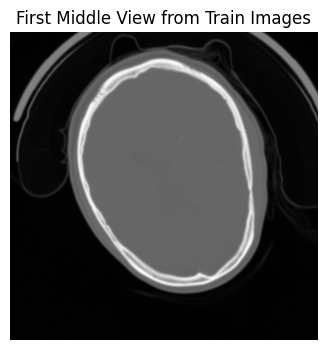

Last file: /content/drive/Othercomputers/My Laptop/BHSD/SPLIT/segmentation/train_images/ID_c3769f3a_ID_32fc557515.nii
Shape: (512, 512, 30), Resolution: (0.48828125, 0.48828125, 5.431885)


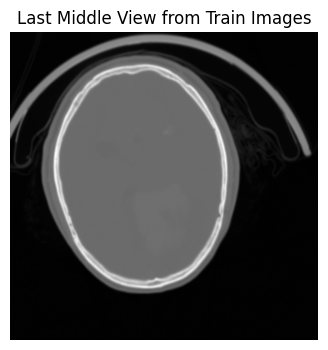


Directory: Train Masks
First file: /content/drive/Othercomputers/My Laptop/BHSD/SPLIT/segmentation/train_masks/ID_69e721e0_ID_a6f36605d7.nii
Shape: (512, 512, 34), Resolution: (0.48828125, 0.48828125, 5.1762695)


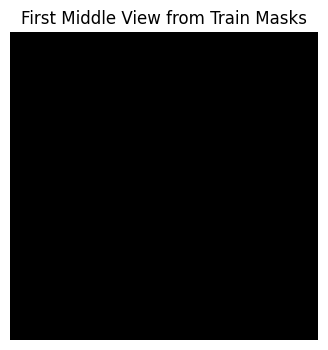

Last file: /content/drive/Othercomputers/My Laptop/BHSD/SPLIT/segmentation/train_masks/ID_c3769f3a_ID_32fc557515.nii
Shape: (512, 512, 30), Resolution: (0.48828125, 0.48828125, 5.431885)


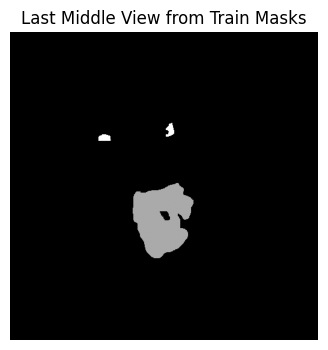

In [85]:
def find_first_and_last_nifti(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii"):
                nifti_files.append(os.path.join(root, file))
    if nifti_files:
        return nifti_files[0], nifti_files[-1]
    return None, None

# Check for both images and masks directories and plot only the top (axial) view
for directory, name in [(SEG_TRAIN_IMG, "Train Images"),
                        (SEG_TRAIN_MASK, "Train Masks")]:
    print(f"\nDirectory: {name}")
    first_path, last_path = find_first_and_last_nifti(directory)
    for path, pos in zip([first_path, last_path], ["First", "Last"]):
        if path:
            nii = nib.load(path)
            img = nii.get_fdata()
            resolution = nii.header.get_zooms()
            print(f"{pos} file: {path}")
            print(f"Shape: {img.shape}, Resolution: {resolution}")

            H, W, D = img.shape[:3]

            top_view = np.transpose(img[:, :, D//2])

            plt.figure(figsize=(4, 4))
            plt.imshow(top_view, cmap='gray')
            plt.title(f"{pos} Middle View from {name}")
            plt.axis('off')
            plt.show()
        else:
            print(f"No {pos} file found in {name}")
            from skimage.transform import rotate  # Ensure rotate is imported

### augmentācija

In [86]:
def zoom(img, mask, p=p):
    if random.random() > p:
        return img, mask

    zoom_factor = random.uniform(0.7, 1.3)
    orig_shape = img.shape[:2]
    new_shape = tuple(max(1, int(round(s * zoom_factor))) for s in orig_shape)

    # Apply same zoom to all depth slices
    img_zoomed = np.stack([
        resize(img[..., c], new_shape, order=1, preserve_range=True, anti_aliasing=True)
        for c in range(img.shape[3])
    ], axis=-1)

    mask_zoomed = np.stack([
        resize(mask[..., c], new_shape, order=0, preserve_range=True, anti_aliasing=False)
        for c in range(mask.shape[3])
    ], axis=-1)

    return img_zoomed, mask_zoomed

In [87]:
def crop(img, mask, height, width, p=p):
    if random.random() > p:
        return img, mask
    crop_x = random.randint(0, max(1, img.shape[0] - height))
    crop_y = random.randint(0, max(1, img.shape[1] - width))
    img = img[crop_x:crop_x + height, crop_y:crop_y + width, :, :]
    mask = mask[crop_x:crop_x + height, crop_y:crop_y + width, :, :]
    return img, mask


In [88]:
def mirroring(img, mask,p=p):
    if random.random() > p:
        img = np.flip(img, axis=0)  # Horizontal flip
        mask = np.flip(mask, axis=0)
    if random.random() > p:
        img = np.flip(img, axis=1)  # Vertical flip
        mask = np.flip(mask, axis=1)
    return img, mask

In [89]:
from scipy.ndimage import rotate

def random_rotate(img, mask, p=p, max_angle=360):
    if random.random() > p:
        return img, mask
    angle = random.uniform(0, max_angle)
    for d in range(img.shape[2]):
        img[:, :, d, :] = rotate(img[:, :, d, :], angle, mode='reflect', reshape=False)
        mask[:, :, d, :] = rotate(mask[:, :, d, :], angle, mode='reflect', reshape=False, order=0)
    return img, mask

In [90]:
def standardize_windows(image, windows):
    windowed_channels = []
    for win in windows:
        windowed_img = apply_window(image, win)
        windowed_channels.append(windowed_img)
    return np.stack(windowed_channels, axis=-1)

In [91]:
def normalize_image(image):
    """
    Normalizes the image so that its values lie within the [0, 1] range.
    """
    min_val = np.min(image)
    max_val = np.max(image)
    if max_val - min_val > 0:
        image = (image - min_val) / (max_val - min_val)  # Normalize to [0,1]
    return image


### processing

In [92]:
threshold = 0.0

class PatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, mask_dir,
                 batch_size=batch_size,
                 patch_size=patch_size,
                 max_patients=None,
                 shuffle=True,
                 augment=False,
                 step_size=step_size,
                 threshold = threshold,
                 **kwargs):
        super().__init__(**kwargs)

        self.image_files = sorted([
            os.path.join(image_dir, f)
            for f in os.listdir(image_dir)
            if f.endswith('.nii')
        ])[:max_patients]

        self.mask_files = sorted([
            os.path.join(mask_dir, f)
            for f in os.listdir(mask_dir)
            if f.endswith('.nii')
        ])[:max_patients]

        assert len(self.image_files) == len(self.mask_files), \
            f"Mismatched images ({len(self.image_files)}) and masks ({len(self.mask_files)})"

        self.batch_size = batch_size
        self.patch_size = patch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.image_files))
        self.on_epoch_end()
        self.all_patches = []
        self.step_size = step_size
        self.threshold = threshold

        self.current_patient_idx = 0  # Tracks progress through patients
        self.buffer = []  # Holds leftover patches across patients

    def __len__(self):
          """Return the number of batches per epoch.
          Since we want one batch per patient, the number of steps is the same as the number of patients.
          """
          return len(self.image_files)  # One batch per patient



    def __getitem__(self, index):
        patient_idx = self.current_patient_idx
        retries = 0
        max_retries_per_patient = 100
        total_attempts = 0

        while retries < max_retries_per_patient:
            patches = self.process_single_volume(patient_idx)
            if patches and len(patches) > 0:
                batch_img = np.array([p[0] for p in patches])
                batch_mask = np.array([p[1] for p in patches])

                # for i, patch in enumerate(batch_img):
                #     plt.figure(figsize=(15, 4))
                #     mid_slice = patch.shape[2] // 2
                #     n_windows = patch.shape[3]
                #     for w in range(n_windows):
                #         plt.subplot(1, n_windows, w+1)
                #         plt.imshow(patch[:, :, mid_slice, w], cmap='jet')
                #         plt.title(f"Window {w+1}")
                #         plt.axis('off')
                #     plt.suptitle(f"Patch {i} Image - Each Window")
                #     plt.show()

                #     # Optionally, also display the corresponding mask
                #     plt.figure(figsize=(6, 6))
                #     mask_patch = batch_mask[i]
                #     plt.imshow(np.argmax(mask_patch, axis=-1)[:, :, mid_slice], cmap='jet')
                #     plt.title(f"Patch {i} Mask (slice {mid_slice})")
                #     plt.axis('off')
                #     plt.show()


                self.current_patient_idx = (patient_idx + 1) % len(self.image_files)
                gc.collect()
                return batch_img, batch_mask
            else:
                print("generating again")
                retries += 1



    # def on_epoch_end(self):
    #   if self.shuffle:
    #     np.random.shuffle(self.indices)
    #   self.epoch_patient_idx = 0
###### shuffling ???????????????????????

    def process_single_volume(self, idx):
        # Load full image and mask volumes
        img = nib.load(self.image_files[idx]).get_fdata()
        mask = nib.load(self.mask_files[idx]).get_fdata().astype(np.uint8)


        # Apply CT window standardization (multi-channel input)
        # Resulting shape: (H, W , D_full, len(windows))

        img = standardize_windows(img, windows)
        img = normalize_image(img)

        # tf.debugging.check_numerics(img, message="After standardize_windows, found NaNs")
        # if img.size == 0:
        #     tf.print("Warning: Standardized image is empty for file:", filename)
        # if np.isnan(img).any():
        #     tf.print("Warning: NaN values found in standardized image for file:", filename)




        # One-hot encode mask for 6 classes and remove background channel
        # Resulting shape: (H, W, D_full, 5)
        mask = tf.one_hot(mask, depth=classes).numpy()


        # ---- Random Augmentation ----
        if self.augment:

          if random.random() > p:
              img, mask = zoom(img, mask, p=p)
              img, mask = crop(img, mask, height, width, p=p)
              img, mask = mirroring(img, mask, p=p)
              img, mask = random_rotate(img, mask, p=p)


        # ---- Resize ----
        img = resize(img, (height, width, img.shape[2], img.shape[3]), order=1, preserve_range=True, anti_aliasing=True)
        mask = resize(mask, (height, width, mask.shape[2], classes), order=0, preserve_range=True, anti_aliasing=False)
        # ---- Patchify the Volume ----


        if np.isnan(img).any():
            tf.print("Warning: NaN values found in resized image for file:", filename)
        if not np.any(img):
            tf.print("Warning: Resized image is completely zero for file:", filename)


        patch_depth = self.patch_size[2]
        step_depth = self.step_size[2]
        current_depth = img.shape[2]
        # print(patch_depth)
        # print(step_depth)
        # print(current_depth)

        remainder = (current_depth - patch_depth) % step_depth

        if remainder != 0:
            pad_amount = step_depth - remainder
            # Pad the image with zeros along axis=2 (depth)
            img = np.pad(img, ((0, 0), (0, 0), (0, pad_amount), (0, 0)), mode='constant', constant_values=0)
            mask = np.pad(mask, ((0, 0), (0, 0), (0, pad_amount), (0, 0)), mode='constant', constant_values=0)

        patches_img = patchify(img, self.patch_size, step=(self.step_size[0], self.step_size[1],
                              self.step_size[2], self.patch_size[3]))
        patches_mask = patchify(mask, (self.patch_size[0], self.patch_size[1], self.patch_size[2], classes),
                            step=(self.step_size[0], self.step_size[1], self.step_size[2], classes))


        # Reshape into list of patches
        num_patches = np.prod(patches_img.shape[:3])
        patches_img = patches_img.reshape(num_patches, *self.patch_size)
        patches_mask = patches_mask.reshape(num_patches, self.patch_size[0], self.patch_size[1], self.patch_size[2],6)

        # ---- Print ALL Patches for Debugging ----
        filename = os.path.basename(self.image_files[idx])
        print(f"\nProcessing: {filename}")
        # print(f"Volume {idx} produced {num_patches} patches:")
        # for j in range(num_patches):
        #     plt.figure(figsize=(10, 4))
        #     # Display middle slice of the patch
        #     plt.subplot(1, 2, 1)
        #     plt.imshow(patches_img[j][:, :, depth // 2, 0],cmap='jet' #cmap='gray'
        #     )
        #     plt.title(f"Patch {j} Image")
        #     plt.subplot(1, 2, 2)
        #     plt.imshow(np.argmax(patches_mask[j], axis=-1)[:, :, depth // 2], cmap='jet')
        #     plt.title(f"Patch {j} Mask")
        #     plt.show()


        # for j, (img_patch, mask_patch) in enumerate(zip(patches_img, patches_mask)):
        #     print(f"Patch {j} - Min: {np.min(img_patch)}, Max: {np.max(img_patch)}")
        #     print(f"Patch {j} Mask Sum: {np.sum(mask_patch)}")

            # class_counts = np.sum(mask_patch[..., 1:], axis=(0, 1, 2))
            # total_foreground = np.sum(class_counts)

            # if total_foreground > 0:
            #     class_percentages = class_counts / total_foreground * 100
            #     print(f"Foreground class voxel counts: {class_counts}")
                #print(f"Foreground class distribution (%): {class_percentages}")


        # ---- Filter Out Empty Patches ----
        non_empty_patches = []
        for img_patch, mask_patch in zip(patches_img, patches_mask):
            total_voxels = np.prod(mask_patch.shape[:-1])
            foreground_voxels = np.sum(mask_patch[..., 1:6])
            if foreground_voxels / total_voxels > self.threshold:
                non_empty_patches.append((img_patch, mask_patch))


        if not non_empty_patches :
            # print(f"Volume {idx}: All patches are empty. Skipping.")
            return None
        else  :
          # print("ok")
            #print(non_empty_patches)
            return non_empty_patches

## Datu apstrāde

In [93]:
# import pandas as pd
# import numpy as np
# import glob
# import os
# import nibabel as nib

# # Define the directory containing the training masks
# mask_dir = SEG_TRAIN_MASK  # make sure SEG_TRAIN_MASK is defined, e.g., '/path/to/train_masks'
# # Get a sorted list of all .nii files in that directory
# mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.nii')))

# # Dictionary to accumulate counts for each label
# total_counts = {}

# for idx, filepath in enumerate(mask_files, 1):
#     try:
#         # Load the NIfTI file and convert data to integer type
#         mask_img = nib.load(filepath)
#         mask_data = mask_img.get_fdata().astype(np.int32)
#         # Get unique labels and their voxel counts in the mask
#         unique, counts = np.unique(mask_data, return_counts=True)
#         for u, count in zip(unique, counts):
#             total_counts[u] = total_counts.get(u, 0) + count
#     except Exception as e:
#         print(f"Error processing {filepath}: {e}")

# # Extract counts for foreground labels (1-5)
# label_1 = total_counts.get(1, 0)
# label_2 = total_counts.get(2, 0)
# label_3 = total_counts.get(3, 0)
# label_4 = total_counts.get(4, 0)
# label_5 = total_counts.get(5, 0)

# # Total voxel counts for foreground labels
# total_labels = label_1 + label_2 + label_3 + label_4 + label_5
# n_classes = 5

# # Compute weights using inverse frequency weighting; add epsilon to avoid division by zero.
# eps = 1e-7
# wt1 = round(total_labels / (n_classes * label_1 + eps), 3)
# wt2 = round(total_labels / (n_classes * label_2 + eps), 3)
# wt3 = round(total_labels / (n_classes * label_3 + eps), 3)
# wt4 = round(total_labels / (n_classes * label_4 + eps), 3)
# wt5 = round(total_labels / (n_classes * label_5 + eps), 3)

# print("Foreground counts:", label_1, label_2, label_3, label_4, label_5)
# print("Weights:", wt1, wt2, wt3, wt4, wt5)


Izvade :
Foreground counts: 126971 1659565 473779 429064 868227
Weights: 5.604 0.429 1.502 1.658 0.82


256x256x8
Patch-based class weights: [0.168, 931.755, 71.288, 249.718, 275.719, 136.199]



In [94]:
wt0, wt1, wt2, wt3, wt4, wt5 = 0.168, 902.026, 68.417, 238.930, 267.165, 130.448

class_weights = tf.constant([wt0, wt1, wt2, wt3, wt4, wt5], dtype=tf.float32)

print(class_weights)

tf.Tensor([1.68000e-01 9.02026e+02 6.84170e+01 2.38930e+02 2.67165e+02 1.30448e+02], shape=(6,), dtype=float32)


[0.168, 902.026, 68.417, 238.930, 267.165, 130.448]

256x256x8//2, tikai test bez augmentation

## Zaudējuma funkcija

In [95]:
def generalized_dice_loss(y_true, y_pred, class_weights, epsilon=1e-7):
    """
    Generalized Dice Loss for multi-class segmentation.
    L_GDL = 1 - 2 * (sum_k w_k sum_i (p_i,k * t_i,k)) / (sum_k w_k sum_i (p_i,k + t_i,k))
    """
    # Ensure inputs are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Flatten spatial dimensions: [B, H, W, D, C] -> [B, H*W*D, C]
    y_true_flat = tf.reshape(y_true, [tf.shape(y_true)[0], -1, tf.shape(y_true)[-1]])
    y_pred_flat = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1, tf.shape(y_pred)[-1]])

    # Compute intersection and union per class
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=1)  # [B, C]
    union = tf.reduce_sum(y_true_flat + y_pred_flat, axis=1)         # [B, C]

    # Apply class weights
    weighted_intersection = tf.reduce_sum(class_weights * intersection, axis=1)  # [B]
    weighted_union = tf.reduce_sum(class_weights * union, axis=1)                # [B]

    # Compute Dice score per batch
    dice_score = (2.0 * weighted_intersection + epsilon) / (weighted_union + epsilon)

    # Return loss as 1 - mean Dice score
    return 1.0 - tf.reduce_mean(dice_score)

In [96]:
def create_dice_metric(class_weights, epsilon=1e-7):
    def dice_metric(y_true, y_pred):
        """
        Weighted Dice metric, consistent with GDL weights.
        Computes Dice score per class, weighted by class_weights.
        """
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Flatten spatial dimensions: [B, H, W, D, C] -> [B, H*W*D, C]
        y_true_flat = tf.reshape(y_true, [tf.shape(y_true)[0], -1, tf.shape(y_true)[-1]])
        y_pred_flat = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1, tf.shape(y_pred)[-1]])

        # Compute intersection and union per class
        intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=1)  # [B, C]
        union = tf.reduce_sum(y_true_flat + y_pred_flat, axis=1)         # [B, C]

        # Compute Dice score per class
        dice_per_class = (2.0 * intersection + epsilon) / (union + epsilon)  # [B, C]

        # Weight by class weights and average across classes and batches
        weighted_dice = tf.reduce_sum(class_weights * dice_per_class, axis=1) / tf.reduce_sum(class_weights)

        return tf.reduce_mean(weighted_dice)
    return dice_metric

# Create the metric function with the pre-defined class_weights
dice_metric = create_dice_metric(class_weights)

In [97]:
def weighted_cce(class_weights, epsilon=1e-7):
    """
    Weighted Categorical Cross-Entropy Loss.
    L_WCE = -1/N sum_i sum_k w_k t_i,k log(p_i,k)
    """
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)  # Avoid log(0)
        weighted_ce = -tf.reduce_mean(
            tf.reduce_sum(class_weights * y_true * tf.math.log(y_pred), axis=-1)
        )
        return weighted_ce
    return loss

In [98]:
def weighted_cce_metric(y_true, y_pred, class_weights, epsilon=1e-7):
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    cce = -tf.reduce_mean(
        tf.reduce_sum(class_weights * y_true * tf.math.log(y_pred), axis=-1)
    )
    return cce

In [99]:
def combined_loss(class_weights, alpha=0.7):
    """
    Combined loss: alpha * L_GDL + (1 - alpha) * L_WCE
    """
    def loss(y_true, y_pred):
        gdl = generalized_dice_loss(y_true, y_pred, class_weights)
        wce = weighted_cce(class_weights)(y_true, y_pred)
        return alpha * gdl + (1 - alpha) * wce
    return loss

### datu ielāde

In [100]:
max_patients=5
train_gen = PatchGenerator(SEG_TRAIN_IMG, SEG_TRAIN_MASK,
                           batch_size=batch_size,
                           max_patients=max_patients,
                           augment=True,
                           shuffle=False)

val_gen = PatchGenerator(SEG_VAL_IMG, SEG_VAL_MASK,
                         batch_size=batch_size,
                         max_patients=max_patients,
                         augment=False,
                         shuffle=False)

test_gen = PatchGenerator(SEG_TEST_IMG, SEG_TEST_MASK,
                          batch_size=batch_size,
                          max_patients=max_patients,
                          augment=False,
                          shuffle=False)

In [101]:
# train_gen.image_files = train_gen.image_files[:2]
# train_gen.mask_files  = train_gen.mask_files[:2]
# train_gen.indices = np.arange(len(train_gen.image_files))

# val_gen.image_files = val_gen.image_files[:2]
# val_gen.mask_files  = val_gen.mask_files[:2]
# val_gen.indices = np.arange(len(val_gen.image_files))

steps_per_epoch = len(train_gen)
val_steps_per_epoch = len(val_gen)

### kanālu standartizācija

In [102]:
def apply_window(image, window):
    """
    Apply a single CT window using the DICOM-standard formula.

    Parameters:
        image  : numpy array, CT image in Hounsfield Units.
        window : list or tuple with [center, width]

    Returns:
        windowed_img: numpy array with values scaled to [0, 1]
    """
    center, width = window
    # Calculate lower and upper bounds per the DICOM formula:
    lower = center - 0.5 - (width - 1) / 2
    upper = center - 0.5 + (width - 1) / 2

    # Clip the image values to the window and normalize to [0, 1]
    windowed = np.clip(image, lower, upper)
    windowed = (windowed - lower) / (upper - lower)
    return windowed


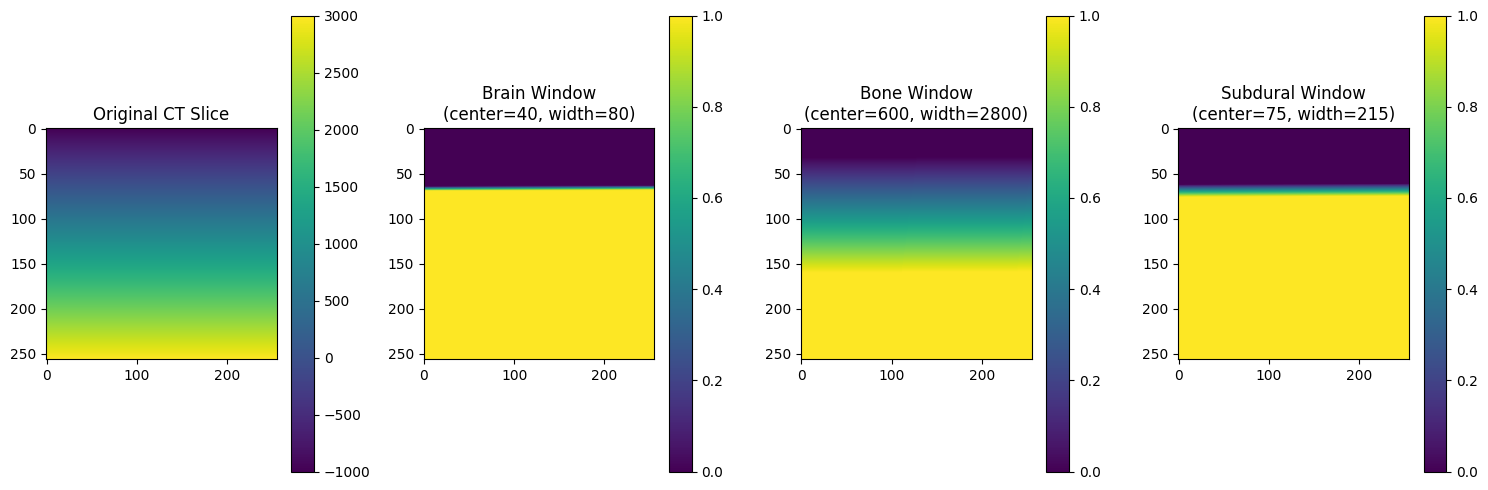

In [103]:
# Create a synthetic CT slice with a range typical for CT Hounsfield Units (e.g., -1000 to 3000)
ct_slice = np.linspace(-1000, 3000, 256*256).reshape(256, 256)

# Apply windowing
brain_img = apply_window(ct_slice, brain_window)
bone_img = apply_window(ct_slice, bone_window)
subdural_img = apply_window(ct_slice, subdural_window)

# Plot the original and windowed images
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(ct_slice)
plt.title("Original CT Slice")
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(brain_img)
plt.title("Brain Window\n(center=40, width=80)")
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(bone_img)
plt.title("Bone Window\n(center=600, width=2800)")
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(subdural_img)
plt.title("Subdural Window\n(center=75, width=215)")
plt.colorbar()

plt.tight_layout()
plt.show()


## Modeļa trenēšana

In [104]:
# import os
# import numpy as np
# import nibabel as nib
# import matplotlib.pyplot as plt

# # --- Find the first image file ---
# nifti_files = []
# for root, dirs, files in os.walk(SEG_TRAIN_IMG):
#     for file in files:
#         if file.endswith(".nii"):
#             nifti_files.append(os.path.join(root, file))

# # Define window settings as a dictionary.
# windows_names = {
#     "Brain": brain_window,
#     "Bone": bone_window,
#     "Subdural": subdural_window,
#     "Stroke": stroke_window
# }

# if len(nifti_files) > 0:
#     # Load image
#     first_img_path = nifti_files[0]
#     nii = nib.load(first_img_path)
#     img = nii.get_fdata()
#     print("First image file:", first_img_path)
#     print("HU range: min =", img.min(), ", max =", img.max())

#     # --- Find the corresponding mask file ---
#     mask_files = []
#     for root, dirs, files in os.walk(SEG_TRAIN_MASK):
#         for file in files:
#             if file.endswith(".nii"):
#                 mask_files.append(os.path.join(root, file))

#     if len(mask_files) > 0:
#         first_mask_path = mask_files[0]
#         mask_nii = nib.load(first_mask_path)
#         mask = mask_nii.get_fdata()
#         print("First mask file:", first_mask_path)
#         print("Mask shape:", mask.shape)
#     else:
#         print("No mask file found in SEG_TRAIN_MASK directory.")
#         mask = None

#     # --- Loop over each depth slice ---
#     H, W, D = img.shape[:3]
#     for d in range(D):
#         slice_img = img[:, :, d]
#         # If mask exists and has at least d slices, extract the corresponding slice;
#         # otherwise, use the middle slice of the mask.
#         if mask is not None:
#             if mask.shape[2] > d:
#                 slice_mask = mask[:, :, d]
#             else:
#                 slice_mask = mask[:, :, mask.shape[2] // 2]
#         # Total subplots: 1 for original + one per window + 1 for mask (if available)
#         n_subplots = len(windows_names) + (2 if mask is not None else 1)
#         fig, axs = plt.subplots(1, n_subplots, figsize=(4 * n_subplots, 5))

#         # Plot the original slice.
#         axs[0].imshow(slice_img, cmap='gray')
#         axs[0].set_title(f"Original\nSlice {d}")
#         axs[0].axis('off')

#         # Plot each windowed version.
#         for i, (win_name, win_vals) in enumerate(windows_names.items(), start=1):
#             win_img = apply_window(slice_img, win_vals)
#             axs[i].imshow(win_img, cmap='gray')
#             axs[i].set_title(f"{win_name}\n(Level={win_vals[0]}, Width={win_vals[1]})")
#             axs[i].axis('off')

#         # If mask exists, plot it as the last subplot.
#         if mask is not None:
#             axs[-1].imshow(slice_mask, cmap='gray')
#             axs[-1].set_title("Mask")
#             axs[-1].axis('off')

#         plt.tight_layout()
#         plt.show()

# else:
#     print("No NIfTI files found in the SEG_TRAIN_IMG directory.")


In [105]:
# def calculate_patch_weights_from_generator(generator):
#     total_counts = np.zeros(6, dtype=np.float32)  # 6 channels: background + 5 classes
#     for i in range(len(generator)):
#         _, batch_mask = generator[i]  # batch_mask shape: (num_patches, H, W, D, 6)
#         # Sum over batch and spatial dimensions to get counts per channel
#         counts = np.sum(batch_mask, axis=(0, 1, 2, 3))
#         total_counts += counts
#     total_voxels = total_counts.sum()
#     n_classes = 6
#     eps = 1e-7
#     weights = total_voxels / (n_classes * (total_counts + eps))

#     print("Voxel counts per class: [" + ", ".join(f"{count:.0f}" for count in total_counts) + "]")
#     print("Total voxels: {:.0f}".format(total_voxels))


#     return weights

# # Instantiate your PatchGenerator with augmentation disabled
# pg = PatchGenerator(SEG_TRAIN_IMG, SEG_TRAIN_MASK,
#                     batch_size=batch_size,
#                     patch_size=patch_size,
#                     max_patients=max_patients,
#                     shuffle=False,
#                     augment=False,
#                     step_size=step_size)

# patch_weights = calculate_patch_weights_from_generator(pg)
# print("Patch-based class weights: [" + ", ".join(f"{w:.3f}" for w in patch_weights) + "]")


output:

Voxel counts per class: [424034144, 210882, 3106742, 906764, 814980, 1498008]

Total voxels: 430571520

Patch-based class weights: [0.169, 340.294, 23.099, 79.141, 88.054, 47.905]

----------------
256x256x4

Voxel counts per class: [137522416, 31745, 414918, 118448, 107278, 217172]

Total voxels: 138411968

Patch-based class weights: [0.168, 726.686, 55.598, 194.758, 215.036, 106.223]

----------------
256x256x8

Voxel counts per class: [176581904, 31745, 414918, 118448, 107278, 217172]

Total voxels: 177471456

Patch-based class weights: [0.168, 931.755, 71.288, 249.718, 275.719, 136.199]

------

256x256x8//2

Voxel counts per class: [337834848, 62749, 827303, 236895, 211859, 433900]

Total voxels: 339607552

Patch-based class weights: [0.168, 902.026, 68.417, 238.930, 267.165, 130.448]

In [106]:
# def calculate_patch_weights_from_generators(generators, gen_names):
#     total_counts_all = np.zeros(6, dtype=np.float32)
#     for gen, name in zip(generators, gen_names):
#         total_counts = np.zeros(6, dtype=np.float32)
#         for i in range(len(gen)):
#             _, batch_mask = gen[i]  # Expected shape: (num_patches, H, W, D, 6)
#             counts = np.sum(batch_mask, axis=(0, 1, 2, 3))
#             total_counts += counts
#         print(f"{name} voxel counts per class: [{', '.join(f'{count:.0f}' for count in total_counts)}]")
#         print(f"{name} total voxels: {total_counts.sum():.0f}\n")
#         total_counts_all += total_counts

#     print(f"All directories total voxel counts per class: [{', '.join(f'{count:.0f}' for count in total_counts_all)}]")
#     print(f"All directories total voxels: {total_counts_all.sum():.0f}\n")

#     n_classes = 6
#     eps = 1e-7
#     weights = total_counts_all.sum() / (n_classes * (total_counts_all + eps))
#     return weights

# # Instantiate PatchGenerators for train, validation, and test directories
# train_gen = PatchGenerator(SEG_TRAIN_IMG, SEG_TRAIN_MASK,
#                            batch_size=batch_size,
#                            patch_size=patch_size,
#                            max_patients=max_patients,
#                            shuffle=False,
#                            augment=False,
#                            step_size=step_size)

# val_gen = PatchGenerator(SEG_VAL_IMG, SEG_VAL_MASK,
#                          batch_size=batch_size,
#                          patch_size=patch_size,
#                          max_patients=max_patients,
#                          shuffle=False,
#                          augment=False,
#                          step_size=step_size)

# test_gen = PatchGenerator(SEG_TEST_IMG, SEG_TEST_MASK,
#                           batch_size=batch_size,
#                           patch_size=patch_size,
#                           max_patients=max_patients,
#                           shuffle=False,
#                           augment=False,
#                           step_size=step_size)

# # Combine generators and their names into lists
# all_generators = [train_gen, val_gen, test_gen]
# generator_names = ["Train", "Validation", "Test"]

# patch_weights = calculate_patch_weights_from_generators(all_generators, generator_names)
# print("Patch-based class weights: [" + ", ".join(f"{w:.3f}" for w in patch_weights) + "]")


ALL

All directories total voxel counts per class: [618663552, 526586, 4448118, 1370932, 1509200, 2102940]


All directories total voxels: 628621312

TRAIN

Train voxel counts per class: [424034144, 210882, 3106742, 906764, 814980, 1498008]

Train total voxels: 430571520

VAL

Validation voxel counts per class: [97670944, 77248, 779096, 271644, 220596, 201988]

Validation total voxels: 99221504

TEST

Test voxel counts per class: [96958448, 238456, 562280, 192524, 473624, 402944]

Test total voxels: 98828280

---------------------------------

256x256x4:

ALL
All directories total voxel counts per class: [199455424, 75468, 590913, 177493, 196959, 305992]

All directories total voxels: 200802240

TRAIN

Train voxel counts per class: [137522416, 31745, 414918, 118448, 107278, 217172]
Train total voxels: 138411968

VAL

Validation voxel counts per class: [30726662, 10251, 103054, 34433, 29070, 29521]
Validation total voxels: 30932992

TEST

Test voxel counts per class: [31206348, 33472, 72941, 24612, 60611, 59299]
Test total voxels: 31457284


### callbacks

In [107]:
class HistorySavingCallback(tf.keras.callbacks.Callback):
    def __init__(self, filepath):
        super().__init__()
        self.filepath = filepath
        if os.path.exists(self.filepath):
            with open(self.filepath, 'rb') as f:
                self.history = pickle.load(f)
            self.epoch_offset = len(self.history.get('loss', []))
            print(f"Loaded existing history with {self.epoch_offset} epochs.")
        else:
            self.history = {}
            self.epoch_offset = 0
            print("No existing history found; starting fresh.")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        logs['lr'] = current_lr
        actual_epoch = self.epoch_offset + epoch + 1
        logs['epoch'] = actual_epoch
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)
        with open(self.filepath, 'wb') as f:
            pickle.dump(self.history, f)
        print(f"History saved for epoch {actual_epoch} to {self.filepath}")

history_filepath = '/content/drive/MyDrive/training_history_epoch_Mamba1000.pkl'


In [108]:
checkpoint_combined_loss = ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, "best_model_diceMamba1000.keras"),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)


In [109]:
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=10,
#     verbose=1
# )

In [110]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        # Access 'learning_rate' instead of 'lr'
        current_lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print(f"Epoch {epoch+1}: Learning rate = {current_lr}")
        logs['lr'] = current_lr


In [111]:
class VisualizePredictions(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, num_samples=1):
        super().__init__()
        self.val_generator = val_generator
        self.num_samples = num_samples

    def on_epoch_end(self, epoch, logs=None):
        sample_img, sample_mask = self.val_generator[0]
        pred = self.model.predict(sample_img)


        dice_score = dice_metric(sample_mask, pred).numpy()

        true_mask = np.argmax(sample_mask, axis=-1)
        pred_mask = np.argmax(pred, axis=-1)
        slice_idx = sample_img.shape[3] // 2
        num_windows = sample_img.shape[-1]
        total_plots = num_windows + 2

        plt.figure(figsize=(4 * total_plots, 5))
        for w in range(num_windows):
            plt.subplot(1, total_plots, w + 1)
            plt.imshow(sample_img[0, :, :, slice_idx, w], cmap='gray')
            plt.title(f"Val Window {w + 1}")
            plt.axis('off')

        plt.subplot(1, total_plots, num_windows + 1)
        plt.imshow(true_mask[0, :, :, slice_idx], cmap='gray')
        plt.title("Val Ground Truth")
        plt.axis('off')

        plt.subplot(1, total_plots, num_windows + 2)
        plt.imshow(pred_mask[0, :, :, slice_idx], cmap='jet')
        plt.title(f"Val Prediction\nDice: {dice_score:.4f}")
        plt.axis('off')

        plt.suptitle(f"Epoch {epoch + 1}")
        plt.show()

In [112]:
class VisualizeTrainPredictions(tf.keras.callbacks.Callback):
    def __init__(self, train_generator, num_samples=1):
        super().__init__()
        self.train_generator = train_generator
        self.num_samples = num_samples

    def on_epoch_end(self, epoch, logs=None):
        # Get a sample batch from the training generator (using index -1 for the last batch)
        sample_img, sample_mask = self.train_generator[-1]
        # Predict on the sample batch
        pred = self.model.predict(sample_img)

        # Convert one-hot encoded masks to label maps via argmax for both ground truth and prediction
        true_mask = np.argmax(sample_mask, axis=-1)
        pred_mask = np.argmax(pred, axis=-1)

        # Use the depth dimension (axis 3) to choose a mid-slice
        slice_idx = sample_img.shape[3] // 2
        # Determine the number of window channels (last dimension)
        num_windows = sample_img.shape[-1]

        # Total subplots: one for each window plus ground truth and prediction
        total_plots = num_windows + 2

        plt.figure(figsize=(4 * total_plots, 5))

        # Plot each window channel of the training image
        for w in range(num_windows):
            plt.subplot(1, total_plots, w + 1)
            plt.imshow(sample_img[0, :, :, slice_idx, w], cmap='gray')
            plt.title(f"Train Window {w+1}")
            plt.axis('off')

        # Plot training ground truth
        plt.subplot(1, total_plots, num_windows + 1)
        plt.imshow(true_mask[0, :, :, slice_idx], cmap='gray')
        plt.title("Train Ground Truth")
        plt.axis('off')

        # Plot training prediction
        plt.subplot(1, total_plots, num_windows + 2)
        plt.imshow(pred_mask[0, :, :, slice_idx], cmap='jet')
        plt.title("Train Prediction")
        plt.axis('off')

        plt.suptitle(f"Training Predictions at Epoch {epoch+1}")
        plt.show()


In [113]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience=patience, restore_best_weights=True)
history_saving_callback = HistorySavingCallback(filepath=history_filepath)
vis_callback = VisualizePredictions(val_gen)
train_vis_callback = VisualizeTrainPredictions(train_gen)
lr_logger = LearningRateLogger()
callbacks_list = [early_stopping,
                  checkpoint_combined_loss,
                  history_saving_callback,
                  train_vis_callback,
                  vis_callback,
                  lr_logger,
                  TqdmCallback(verbose=1)
                  ]


# Verify configuration
print(f"Total training patients: {len(train_gen.image_files)}")
print(f"Total validation patients: {len(val_gen.image_files)}")
print(f"Steps per epoch: {len(train_gen)}")


No existing history found; starting fresh.


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Total training patients: 100
Total validation patients: 28
Steps per epoch: 100


### train model

In [114]:
print(torch.cuda.is_available())

False


In [115]:
# Fixed PyTorch 3D U-Net with Tri-Oriented Internal Mamba (no external deps)
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------------
# Internal SSM-like module
# -------------------------
class InternalSSM(nn.Module):
    """
    Lightweight SSM-like module implemented with pure PyTorch.
    Input: (N, L, C)
    Output: (N, L, C)
    - Projects to expanded channels, uses depthwise Conv1d (causal), gating, projection back.
    """
    def __init__(self, d_model: int, kernel_size: int = 9, expand: int = 2):
        super().__init__()
        self.d_model = d_model
        self.expand = expand
        mid = d_model * expand

        # Project to expanded channels (pointwise)
        self.to_mid = nn.Linear(d_model, mid, bias=True)

        # Depthwise conv over sequence dimension (Conv1d expects (N, C, L))
        self.kernel_size = kernel_size
        # Use padding=kernel_size-1 and then take last L elements to maintain causality
        self.depthwise_conv = nn.Conv1d(mid, mid, kernel_size, padding=kernel_size - 1, groups=mid, bias=True)

        # Gating + output projection
        self.gate = nn.Linear(mid, d_model)
        self.out = nn.Linear(mid, d_model)

        # Small normalization
        self.norm = nn.LayerNorm(d_model)

    def forward(self, seq: torch.Tensor) -> torch.Tensor:
        # seq: (N, L, C)
        N, L, C = seq.shape
        assert C == self.d_model, f"d_model mismatch: expected {self.d_model}, got {C}"

        mid = self.to_mid(seq)                 # (N, L, mid)
        mid_t = mid.permute(0, 2, 1).contiguous()  # (N, mid, L)

        conv = self.depthwise_conv(mid_t)      # (N, mid, L + pad)
        conv = conv[:, :, -L:]                 # keep last L (causal)
        conv = conv.permute(0, 2, 1).contiguous()  # (N, L, mid)

        g = torch.sigmoid(self.gate(conv))     # (N, L, d_model)
        o = self.out(conv)                     # (N, L, d_model)
        out = g * o                            # (N, L, d_model)

        out = self.norm(out + seq)
        return out                              # (N, L, d_model)


class InternalMamba(nn.Module):
    """
    Small wrapper that matches expected Mamba interface sufficiently:
    accepts (N, L, C) and returns (N, L, C).
    """
    def __init__(self, d_model: int, kernel_size: int = 9, expand: int = 2):
        super().__init__()
        self.ssm = InternalSSM(d_model=d_model, kernel_size=kernel_size, expand=expand)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.GELU(),
            nn.Linear(d_model * 2, d_model)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        s = self.ssm(x)
        f = self.ff(s)
        return s + f

# -------------------------
# Tri-Oriented Block (no external Mamba)
# -------------------------
class TriOrientedMambaBlock_NoExt(nn.Module):
    """
    Tri-oriented mixture block using InternalMamba for three orientations.
    Input x: (N, C, D, H, W)
    Output: (N, C, D, H, W) (residual)
    """
    def __init__(self, channels: int, ssm_dim: int = 64, dropout_rate: float = 0.1,
                 kernel_size: int = 9, expand: int = 2):
        super().__init__()
        self.channels = channels
        # Use InternalMamba instances (one per orientation)
        self.mamba_forward = InternalMamba(d_model=channels, kernel_size=kernel_size, expand=expand)
        self.mamba_width   = InternalMamba(d_model=channels, kernel_size=kernel_size, expand=expand)
        self.mamba_depth   = InternalMamba(d_model=channels, kernel_size=kernel_size, expand=expand)

        self.norm = nn.InstanceNorm3d(channels, affine=True)
        self.dropout = nn.Dropout3d(p=dropout_rate)
        self.act = nn.GELU()

    def _apply_internal(self, x: torch.Tensor, mamba: InternalMamba) -> torch.Tensor:
        # x: (N, C, D, H, W) -> flatten to (N, L, C)
        N, C, D, H, W = x.shape
        seq = x.permute(0, 2, 3, 4, 1).contiguous().view(N, D * H * W, C)  # (N, L, C)
        out = mamba(seq)  # (N, L, C)
        out = out.view(N, D, H, W, C).permute(0, 4, 1, 2, 3).contiguous()  # (N, C, D, H, W)
        return out

    def _apply_internal_swapped(self, x: torch.Tensor, mamba: InternalMamba, swap: str) -> torch.Tensor:
        # swap orientations similar to original scheme
        if swap == "hw":  # swap H and W
            x_sw = x.permute(0, 1, 2, 4, 3).contiguous()     # (N, C, D, W, H)
            y_sw = self._apply_internal(x_sw, mamba)         # (N, C, D, W, H)
            return y_sw.permute(0, 1, 2, 4, 3).contiguous()  # back to (N, C, D, H, W)
        elif swap == "dh":  # depth-first orientation
            # bring D to last, then treat as spatial flattening then permute back
            x_sw = x.permute(0, 1, 3, 4, 2).contiguous()     # (N, C, H, W, D)
            x_sw = x_sw.permute(0, 1, 4, 2, 3).contiguous()  # (N, C, D, H, W)
            return self._apply_internal(x_sw, mamba)
        else:
            return self._apply_internal(x, mamba)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y_f = self._apply_internal(x, self.mamba_forward)
        y_w = self._apply_internal_swapped(x, self.mamba_width, swap="hw")
        y_d = self._apply_internal_swapped(x, self.mamba_depth, swap="dh")

        y = (y_f + y_w + y_d) / 3.0
        y = self.norm(y)
        y = self.act(y)
        y = self.dropout(y)
        return x + y  # residual

# -------------------------
# Convolution + Norm + Activation block
# -------------------------
class ConvNormAct(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv3d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding)
        self.norm = nn.InstanceNorm3d(out_ch, affine=True)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.act(self.norm(self.conv(x)))

# -------------------------
# Full UNet using TriOrientedMambaBlock_NoExt
# -------------------------
class UNet3DMamba(nn.Module):
    def __init__(self, in_channels: int = 4, num_classes: int = 6,
                 base_filters: int = 32,
                 ssm_dims = (64, 128, 256, 256, 256)):
        super().__init__()
        f32, f64, f128, f256, f512 = base_filters, base_filters*2, base_filters*4, base_filters*8, base_filters*16

        # Encoder
        self.enc_in = ConvNormAct(in_channels, f32, kernel_size=3, stride=1, padding=1)
        self.m1 = TriOrientedMambaBlock_NoExt(f32, ssm_dim=ssm_dims[0])
        self.down1 = ConvNormAct(f32, f64, kernel_size=3, stride=(1, 2, 2), padding=1)

        self.m2 = TriOrientedMambaBlock_NoExt(f64, ssm_dim=ssm_dims[1])
        self.down2 = ConvNormAct(f64, f128, kernel_size=3, stride=(1, 2, 2), padding=1)

        self.m3 = TriOrientedMambaBlock_NoExt(f128, ssm_dim=ssm_dims[2])
        self.down3 = ConvNormAct(f128, f256, kernel_size=3, stride=(1, 2, 2), padding=1)

        self.m4 = TriOrientedMambaBlock_NoExt(f256, ssm_dim=ssm_dims[3])
        self.down4 = ConvNormAct(f256, f512, kernel_size=3, stride=(1, 2, 2), padding=1)

        self.m5 = TriOrientedMambaBlock_NoExt(f512, ssm_dim=ssm_dims[4])
        self.base = ConvNormAct(f512, f512*2, kernel_size=3, stride=(1, 2, 2), padding=1)  # -> 1024

        # Decoder with skip connections
        self.up1 = ConvNormAct(f512*2, f512)
        self.dec1 = ConvNormAct(f512 + f512, f512)

        self.up2 = ConvNormAct(f512, f256)
        self.dec2 = ConvNormAct(f256 + f256, f256)

        self.up3 = ConvNormAct(f256, f128)
        self.dec3 = ConvNormAct(f128 + f128, f128)

        self.up4 = ConvNormAct(f128, f64)
        self.dec4 = ConvNormAct(f64 + f64, f64)

        self.up5 = ConvNormAct(f64, f32)
        self.dec5 = ConvNormAct(f32 + f32, f32)

        self.out_conv = nn.Conv3d(f32, num_classes, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (N, C, D, H, W)
        x1 = self.m1(self.enc_in(x))              # (N, f32, D, H, W)
        x2_in = self.down1(x1)                    # (N, f64, D, H/2, W/2)
        x2 = self.m2(x2_in)
        x3_in = self.down2(x2)                    # (N, f128, D, H/4, W/4)
        x3 = self.m3(x3_in)
        x4_in = self.down3(x3)                    # (N, f256, D, H/8, W/8)
        x4 = self.m4(x4_in)
        x5_in = self.down4(x4)                    # (N, f512, D, H/16, W/16)
        x5 = self.m5(x5_in)
        base = self.base(x5)                      # (N, f512*2, D, H/32, W/32)

        # Decoder path
        u = F.interpolate(base, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)
        u = self.up1(u)
        u = torch.cat([u, x5], dim=1)
        u = self.dec1(u)

        u = F.interpolate(u, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)
        u = self.up2(u)
        u = torch.cat([u, x4], dim=1)
        u = self.dec2(u)

        u = F.interpolate(u, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)
        u = self.up3(u)
        u = torch.cat([u, x3], dim=1)
        u = self.dec3(u)

        u = F.interpolate(u, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)
        u = self.up4(u)
        u = torch.cat([u, x2], dim=1)
        u = self.dec4(u)

        u = F.interpolate(u, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)
        u = self.up5(u)
        u = torch.cat([u, x1], dim=1)
        u = self.dec5(u)

        logits = self.out_conv(u)  # (N, num_classes, D, H, W)
        return logits

# -------------------------
# Utility
# -------------------------
def _ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

# -------------------------
# Quick smoke test (uncomment to run)
# -------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet3DMamba(in_channels=4, num_classes=6, base_filters=16).to(device)  # smaller base_filters for test
    x = torch.randn(1, 4, 8, 128, 128, device=device)  # (N, C, D, H, W)
    with torch.no_grad():
        y = model(x)
    print("Input:", x.shape, "Output:", y.shape)


Input: torch.Size([1, 4, 8, 128, 128]) Output: torch.Size([1, 6, 8, 128, 128])


In [116]:
# # PyTorch 3D U-Net with Tri-Oriented Mamba SSM blocks (trainable)


# def _ensure_dir(path: str):
# 	os.makedirs(path, exist_ok=True)


# class TriOrientedMambaBlock_NoExt(TriOrientedMambaBlock_NoExt):
# 	def __init__(self, channels: int, ssm_dim: int, dropout_rate: float = 0.1):
# 		super().__init__()
# 		self.channels = channels
# 		self.mamba_forward = Mamba(d_model=channels, d_state=ssm_dim, d_conv=3, expand=2)
# 		self.mamba_reverse = Mamba(d_model=channels, d_state=ssm_dim, d_conv=3, expand=2)
# 		self.mamba_depth = Mamba(d_model=channels, d_state=ssm_dim, d_conv=3, expand=2)
# 		self.norm = nn.InstanceNorm3d(channels, affine=True)
# 		self.dropout = nn.Dropout3d(p=dropout_rate)
# 		self.act = nn.GELU()

# 	@torch.cuda.amp.autocast(enabled=False)
# 	def _apply_mamba(self, x: torch.Tensor, mamba: Mamba) -> torch.Tensor:
# 		# x: (N, C, D, H, W)
# 		N, C, D, H, W = x.shape
# 		# flatten to sequence length L = D*H*W with feature dim C
# 		seq = x.permute(0, 2, 3, 4, 1).contiguous().view(N, D * H * W, C)  # (N, L, C)
# 		out = mamba(seq)  # (N, L, C)
# 		out = out.view(N, D, H, W, C).permute(0, 4, 1, 2, 3).contiguous()  # (N, C, D, H, W)
# 		return out

# 	def forward(self, x: torch.Tensor) -> torch.Tensor:
# 		# Orientation 1: as-is (scan by H then W then D via flatten)
# 		x_fwd = self._apply_mamba(x, self.mamba_forward)

# 		# Orientation 2: swap H and W before flattening
# 		x_hw = x.permute(0, 1, 2, 4, 3).contiguous()  # (N, C, D, W, H)
# 		x_rev = self._apply_mamba(x_hw, self.mamba_reverse)
# 		x_rev = x_rev.permute(0, 1, 2, 4, 3).contiguous()  # back to (N, C, D, H, W)

# 		# Orientation 3: Depth-first
# 		x_d = x.permute(0, 1, 3, 4, 2).contiguous()  # (N, C, H, W, D)
# 		x_d = x_d.permute(0, 1, 4, 2, 3).contiguous()  # (N, C, D, H, W)
# 		x_depth = self._apply_mamba(x_d, self.mamba_depth)

# 		# Combine
# 		out = (x_fwd + x_rev + x_depth) / 3.0
# 		out = self.norm(out)
# 		out = self.act(out)
# 		out = self.dropout(out)
# 		return out + x  # residual


# class ConvNormAct(nn.Module):
# 	def __init__(self, in_ch: int, out_ch: int, kernel_size=3, stride=1, padding=1):
# 		super().__init__()
# 		self.conv = nn.Conv3d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding)
# 		self.norm = nn.InstanceNorm3d(out_ch, affine=True)
# 		self.act = nn.GELU()

# 	def forward(self, x: torch.Tensor) -> torch.Tensor:
# 		return self.act(self.norm(self.conv(x)))


# class UNet3DMamba(nn.Module):
# 	def __init__(self, in_channels: int = 4, num_classes: int = 6,
# 				 base_filters: int = 32,
# 				 ssm_dims = (64, 128, 256, 256, 256)):
# 		super().__init__()
# 		f32, f64, f128, f256, f512 = base_filters, base_filters*2, base_filters*4, base_filters*8, base_filters*16
# 		# Encoder
# 		self.enc_in = ConvNormAct(in_channels, f32, kernel_size=3, stride=1, padding=1)  # keep spatial
# 		self.m1 = TriOrientedMambaBlock_NoExt(f32, ssm_dim=ssm_dims[0])
# 		self.down1 = ConvNormAct(f32, f64, kernel_size=3, stride=(1, 2, 2), padding=1)

# 		self.m2 = TriOrientedMambaBlock_NoExt(f64, ssm_dim=ssm_dims[1])
# 		self.down2 = ConvNormAct(f64, f128, kernel_size=3, stride=(1, 2, 2), padding=1)

# 		self.m3 = TriOrientedMambaBlock_NoExt(f128, ssm_dim=ssm_dims[2])
# 		self.down3 = ConvNormAct(f128, f256, kernel_size=3, stride=(1, 2, 2), padding=1)

# 		self.m4 = TriOrientedMambaBlock_NoExt(f256, ssm_dim=ssm_dims[3])
# 		self.down4 = ConvNormAct(f256, f512, kernel_size=3, stride=(1, 2, 2), padding=1)

# 		self.m5 = TriOrientedMambaBlock_NoExt(f512, ssm_dim=ssm_dims[4])
# 		self.base = ConvNormAct(f512, f512*2, kernel_size=3, stride=(1, 2, 2), padding=1)  # -> 1024

# 		# Decoder with skip connections
# 		self.up1 = ConvNormAct(f512*2, f512)  # after upsample from 1024
# 		self.dec1 = ConvNormAct(f512 + f512, f512)

# 		self.up2 = ConvNormAct(f512, f256)
# 		self.dec2 = ConvNormAct(f256 + f256, f256)

# 		self.up3 = ConvNormAct(f256, f128)
# 		self.dec3 = ConvNormAct(f128 + f128, f128)

# 		self.up4 = ConvNormAct(f128, f64)
# 		self.dec4 = ConvNormAct(f64 + f64, f64)

# 		self.up5 = ConvNormAct(f64, f32)
# 		self.dec5 = ConvNormAct(f32 + f32, f32)

# 		self.out_conv = nn.Conv3d(f32, num_classes, kernel_size=1)

# 	def forward(self, x: torch.Tensor) -> torch.Tensor:
# 		# x: (N, C, D, H, W) with D kept fixed (depth=8)
# 		x1 = self.m1(self.enc_in(x))              # (N, 32, D, 256, 256)
# 		x2_in = self.down1(x1)                    # (N, 64, D, 128, 128)
# 		x2 = self.m2(x2_in)
# 		x3_in = self.down2(x2)                    # (N, 128, D, 64, 64)
# 		x3 = self.m3(x3_in)
# 		x4_in = self.down3(x3)                    # (N, 256, D, 32, 32)
# 		x4 = self.m4(x4_in)
# 		x5_in = self.down4(x4)                    # (N, 512, D, 16, 16)
# 		x5 = self.m5(x5_in)
# 		base = self.base(x5)                      # (N, 1024, D, 8, 8)

# 		# Decoder path
# 		u = F.interpolate(base, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)  # (N, 1024, D, 16, 16)
# 		u = self.up1(u)
# 		u = torch.cat([u, x5], dim=1)  # concat with encoder level 5 (512)
# 		u = self.dec1(u)

# 		u = F.interpolate(u, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)     # (N, 512, D, 32, 32)
# 		u = self.up2(u)
# 		u = torch.cat([u, x4], dim=1)
# 		u = self.dec2(u)

# 		u = F.interpolate(u, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)     # (N, 256, D, 64, 64)
# 		u = self.up3(u)
# 		u = torch.cat([u, x3], dim=1)
# 		u = self.dec3(u)

# 		u = F.interpolate(u, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)     # (N, 128, D, 128, 128)
# 		u = self.up4(u)
# 		u = torch.cat([u, x2], dim=1)
# 		u = self.dec4(u)

# 		u = F.interpolate(u, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)     # (N, 64, D, 256, 256)
# 		u = self.up5(u)
# 		u = torch.cat([u, x1], dim=1)
# 		u = self.dec5(u)

# 		logits = self.out_conv(u)  # (N, num_classes, D, H, W)
# 		return logits

# model = UNet3DMamba(in_channels=4, num_classes=6, base_filters=32).to(device)
# model.summary()

In [117]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv3D, UpSampling3D, Dense, Flatten, Reshape, Layer
# from tensorflow.keras.models import Model
# import torch

# class InstanceNormalization(Layer):
#     def __init__(self, epsilon=1e-5):
#         super(InstanceNormalization, self).__init__()
#         self.epsilon = epsilon

#     def build(self, input_shape):
#         # Learnable scale and offset parameters for each channel
#         self.scale = self.add_weight(name='scale',
#                                      shape=(input_shape[-1],),
#                                      initializer='ones',
#                                      trainable=True)
#         self.offset = self.add_weight(name='offset',
#                                       shape=(input_shape[-1],),
#                                       initializer='zeros',
#                                       trainable=True)

#     def call(self, x):
#         # Compute mean and variance over spatial dimensions (height, width, depth) per batch and channel
#         mean, variance = tf.nn.moments(x, axes=[1, 2, 3], keepdims=True)
#         # Normalize the input
#         normalized = (x - mean) / tf.sqrt(variance + self.epsilon)
#         # Apply scale and offset
#         return self.scale * normalized + self.offset

# class TriOrientedMambaBlock(tf.keras.layers.Layer):
#     def __init__(self, filters, ssm_dim, dropout_rate=0.1):
#         super().__init__()
#         self.filters = filters
#         self.ssm_dim = ssm_dim
#         self.dropout_rate = dropout_rate

#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         self.mamba_forward = Mamba(d_model=filters, d_state=ssm_dim, d_conv=3, expand=2).to(self.device)
#         self.mamba_reverse = Mamba(d_model=filters, d_state=ssm_dim, d_conv=3, expand=2).to(self.device)
#         self.mamba_depth = Mamba(d_model=filters, d_state=ssm_dim, d_conv=3, expand=2).to(self.device)

#         self.norm = InstanceNormalization()
#         self.dropout = tf.keras.layers.Dropout(dropout_rate)

#     def call(self, inputs, training=False):
#         batch_dim = tf.shape(inputs)[0]
#         H = tf.shape(inputs)[1]
#         W = tf.shape(inputs)[2]
#         D = tf.shape(inputs)[3]
#         C = inputs.shape[-1]

#         # Forward direction (along height)
#         seq_len = H * W * D
#         x_forward = tf.reshape(inputs, [batch_dim, seq_len, C])
#         x_forward = tf.py_function(
#             lambda x: self.mamba_forward(
#                 torch.from_numpy(np.array(x)).float().to(self.device)
#             ).detach().cpu().numpy(),
#             [x_forward], tf.float32
#         )
#         x_forward = tf.stop_gradient(x_forward)  # Prevent gradients through Mamba
#         x_forward.set_shape([None, None, C])
#         x_forward = tf.reshape(x_forward, [batch_dim, H, W, D, C])

#         # Reverse direction (along width)
#         x_reverse = tf.transpose(inputs, [0, 2, 1, 3, 4])
#         seq_len_reverse = W * H * D
#         x_reverse = tf.reshape(x_reverse, [batch_dim, seq_len_reverse, C])
#         x_reverse = tf.py_function(
#             lambda x: self.mamba_reverse(
#                 torch.from_numpy(np.array(x)).float().to(self.device)
#             ).detach().cpu().numpy(),
#             [x_reverse], tf.float32
#         )
#         x_reverse = tf.stop_gradient(x_reverse)  # Prevent gradients through Mamba
#         x_reverse.set_shape([None, None, C])
#         x_reverse = tf.reshape(x_reverse, [batch_dim, W, H, D, C])
#         x_reverse = tf.transpose(x_reverse, [0, 2, 1, 3, 4])

#         # Depth direction (inter-slice)
#         x_depth = tf.transpose(inputs, [0, 3, 1, 2, 4])
#         seq_len_depth = D * H * W
#         x_depth = tf.reshape(x_depth, [batch_dim, seq_len_depth, C])
#         x_depth = tf.py_function(
#             lambda x: self.mamba_depth(
#                 torch.from_numpy(np.array(x)).float().to(self.device)
#             ).detach().cpu().numpy(),
#             [x_depth], tf.float32
#         )
#         x_depth = tf.stop_gradient(x_depth)  # Prevent gradients through Mamba
#         x_depth.set_shape([None, None, C])
#         x_depth = tf.reshape(x_depth, [batch_dim, D, H, W, C])
#         x_depth = tf.transpose(x_depth, [0, 2, 3, 1, 4])

#         # Combine and normalize
#         x = (x_forward + x_reverse + x_depth) / 3.0
#         x = self.norm(x)
#         x = tf.keras.activations.gelu(x)
#         x = self.dropout(x, training=training)
#         return x + inputs  # Residual connection

In [118]:
# def build_segResMamba(input_shape, num_classes=6):
#     inputs = Input(shape=input_shape)  # e.g., (256, 256, 8, 4)

#     # Encoder: Filters increase from 32 to 1024
#     x = Conv3D(32, kernel_size=3, padding='same', activation='gelu')(inputs)  # (256, 256, 8, 32)
#     x1 = TriOrientedMambaBlock(filters=32, ssm_dim=64)(x)
#     x1_down = Conv3D(64, kernel_size=3, strides=(2, 2, 1), padding='same', activation='gelu')(x1)  # (128, 128, 8, 64)

#     x2 = TriOrientedMambaBlock(filters=64, ssm_dim=128)(x1_down)
#     x2_down = Conv3D(128, kernel_size=3, strides=(2, 2, 1), padding='same', activation='gelu')(x2)  # (64, 64, 8, 128)

#     x3 = TriOrientedMambaBlock(filters=128, ssm_dim=256)(x2_down)
#     x3_down = Conv3D(256, kernel_size=3, strides=(2, 2, 1), padding='same', activation='gelu')(x3)  # (32, 32, 8, 256)

#     x4 = TriOrientedMambaBlock(filters=256, ssm_dim=256)(x3_down)
#     x4_down = Conv3D(512, kernel_size=3, strides=(2, 2, 1), padding='same', activation='gelu')(x4)  # (16, 16, 8, 512)

#     # New level
#     x5 = TriOrientedMambaBlock(filters=512, ssm_dim=256)(x4_down)
#     x5_down = Conv3D(1024, kernel_size=3, strides=(2, 2, 1), padding='same', activation='gelu')(x5)  # (8, 8, 8, 1024)

#     # Decoder: Filters decrease from 1024 to 32
#     x = UpSampling3D(size=(2, 2, 1))(x5_down)  # (8, 8, 8, 1024) -> (16, 16, 8, 1024)
#     x = Conv3D(512, kernel_size=3, padding='same', activation='gelu')(x)  # (16, 16, 8, 512)
#     x = InstanceNormalization()(x)

#     x = UpSampling3D(size=(2, 2, 1))(x)  # (16, 16, 8, 512) -> (32, 32, 8, 512)
#     x = Conv3D(256, kernel_size=3, padding='same', activation='gelu')(x)  # (32, 32, 8, 256)
#     x = InstanceNormalization()(x)

#     x = UpSampling3D(size=(2, 2, 1))(x)  # (32, 32, 8, 256) -> (64, 64, 8, 256)
#     x = Conv3D(128, kernel_size=3, padding='same', activation='gelu')(x)  # (64, 64, 8, 128)
#     x = InstanceNormalization()(x)

#     x = UpSampling3D(size=(2, 2, 1))(x)  # (64, 64, 8, 128) -> (128, 128, 8, 128)
#     x = Conv3D(64, kernel_size=3, padding='same', activation='gelu')(x)  # (128, 128, 8, 64)
#     x = InstanceNormalization()(x)

#     x = UpSampling3D(size=(2, 2, 1))(x)  # (128, 128, 8, 64) -> (256, 256, 8, 64)
#     x = Conv3D(32, kernel_size=3, padding='same', activation='gelu')(x)  # (256, 256, 8, 32)
#     x = InstanceNormalization()(x)

#     # Output layer
#     outputs = Conv3D(num_classes, kernel_size=1, activation='softmax')(x)  # (256, 256, 8, 6)

#     return Model(inputs, outputs)

# # Define input shape and build the model
# input_shape = (patch_size[0], patch_size[1], patch_size[2], len(windows))
# model = build_segResMamba(input_shape=input_shape, num_classes=6)
# model.summary()

In [119]:
class CyclicLR:
    def __init__(self, initial_learning_rate, maximal_learning_rate, step_size, scale_fn=None):
        self.base_lr = initial_learning_rate
        self.max_lr = maximal_learning_rate
        self.step_size = step_size
        self.scale_fn = scale_fn or (lambda cycle: 1.0)
        self.iteration = 0

    def step(self, optimizer):
        cycle = math.floor(1 + self.iteration / (2 * self.step_size))
        x = abs(self.iteration / self.step_size - 2 * cycle + 1)
        lr = self.base_lr + (self.max_lr - self.base_lr) * max(0.0, 1 - x)
        lr = lr * self.scale_fn(cycle)

        for group in optimizer.param_groups:
            group["lr"] = lr

        self.iteration += 1


## lr finder

In [120]:
class LearningRateFinder(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr=1e-6, max_lr=1e-2, lr_exp_factor=1.01, stop_factor=4.0):
        super().__init__()
        self.initial_lr = initial_lr
        self.max_lr = max_lr
        self.lr_exp_factor = lr_exp_factor
        self.lr_values = []
        self.loss_values = []

    def on_train_begin(self, logs=None):
        # Directly set the optimizer's learning_rate as a tf.Variable
        self.model.optimizer.learning_rate = tf.Variable(self.initial_lr, dtype=tf.float32)
        print("Optimizer learning_rate set to", self.model.optimizer.learning_rate.numpy())

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        # Get the current learning rate
        lr = self.model.optimizer.learning_rate.numpy()
        loss = logs.get('loss')
        self.lr_values.append(lr)
        self.loss_values.append(loss)

        # Increase the learning rate by the exponential factor
        new_lr = lr * self.lr_exp_factor
        if new_lr > self.max_lr:
            self.model.stop_training = True
        else:
            self.model.optimizer.learning_rate.assign(new_lr)

In [121]:
# # Suppose you have a generator or dataset named `train_gen_subset`
# # that yields a small fraction of your 3D data.

# lr_finder = LearningRateFinder(initial_lr=1e-6, max_lr=1e-2, lr_exp_factor=1.05)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True, clipnorm=1.0)
# model.compile(optimizer=optimizer,
#               loss=combined_loss(class_weights, alpha=0.7),
#                metrics=[dice_metric, 'accuracy', weighted_cce_metric])

# model.fit(
#     train_gen,
#     steps_per_epoch=100,  # just enough steps to see a range of LRs
#     epochs=1,             # 1 epoch is typically enough
#     callbacks=[lr_finder]
# )

# # Retrieve the LR-vs-Loss info
# lrs = lr_finder.lr_values
# losses = lr_finder.loss_values


In [122]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8,6))
# plt.plot(lrs, losses)
# plt.xscale('log')
# plt.ylim([0, max(losses)])  # optionally set a reasonable y-limit
# plt.xlabel('Learning Rate (log scale)')
# plt.ylabel('Loss')
# plt.title('LR Range Test')
# plt.show()


## model training

In [123]:
# Example parameters for CLR:
initial_lr = 1e-5        # minimum learning rate
max_lr = 1e-2            # maximum learning rate
step_size = 670          # number of iterations per half cycle. 1 cycle = 10 epochs


In [124]:
# Create the cyclic learning rate schedule
clr_schedule = CyclicLR(initial_learning_rate=initial_lr,
                        maximal_learning_rate=max_lr,
                        step_size=step_size)

In [125]:
class SGD:
    def __init__(self, learning_rate, momentum=0.0, nesterov=False):
        self.lr_schedule = learning_rate
        self.momentum = momentum
        self.nesterov = nesterov

    def build(self, params):
        return torch.optim.SGD(
            params,
            lr=self.lr_schedule.base_lr,
            momentum=self.momentum,
            nesterov=self.nesterov
        )


In [126]:
class TorchModel:
    def __init__(self, pytorch_model):
        self.model = pytorch_model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def compile(self, optimizer, loss, metrics=None):
        self.loss_fn = loss
        self.metrics = metrics or []
        self.optimizer = optimizer.build(self.model.parameters())
        self.lr_schedule = optimizer.lr_schedule

    def train_step(self, x, y):
        self.model.train()

        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()

        # Fix channel order: NHWDC → NCDHW
        if x.ndim == 5:
            x = x.permute(0, 4, 3, 1, 2)

        # Move to device
        x = x.to(self.device)
        y = y.to(self.device)

        preds = self.model(x)
        loss = self.loss_fn(preds, y)

        loss.backward()
        self.optimizer.step()

        metric_results = {}
        for m in self.metrics:
            metric_results[m.__name__] = m(y, preds).item()

        return {"loss": loss.item(), **metric_results}

    def test_step(self, x, y):
        self.model.eval()

        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()

        # Fix channel order: NHWDC → NCDHW
        if x.ndim == 5:
            x = x.permute(0, 4, 3, 1, 2)

        x = x.to(self.device)
        y = y.to(self.device)

        with torch.no_grad():
            preds = self.model(x)
            loss = self.loss_fn(y, preds)

        metric_results = {}
        for m in self.metrics:
            metric_results[m.__name__] = m(y, preds).item()

        return {"val_loss": loss.item(), **metric_results}

    def fit(self, generator, epochs=1, validation_data=None):
        history = {"loss": [], "val_loss": []}

        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            epoch_losses = []

            for batch in generator:
                x, y = batch
                loss = self.train_step(x, y)
                epoch_losses.append(loss)

            avg_loss = sum(epoch_losses) / len(epoch_losses)
            history["loss"].append(avg_loss)
            print(f" - loss: {avg_loss:.4f}")

            # validation
            if validation_data is not None:
                val_losses = []
                self.model.eval()
                with torch.no_grad():
                    for vx, vy in validation_data:
                        vx, vy = vx.to(self.device), vy.to(self.device)
                        preds = self.model(vx)
                        vloss = self.loss_fn(preds, vy).item()
                        val_losses.append(vloss)

                avg_val = sum(val_losses) / len(val_losses)
                history["val_loss"].append(avg_val)
                print(f" - val_loss: {avg_val:.4f}")

        return history

    def evaluate(self, generator):
        self.model.eval()
        total = 0
        with torch.no_grad():
            for x, y in generator:
                x, y = x.to(self.device), y.to(self.device)
                pred = self.model(x)
                loss = self.loss_fn(pred, y)
                total += loss.item()
        return total / len(generator)

    def predict(self, x):
        self.model.eval()
        with torch.no_grad():
            x = x.to(self.device)
            preds = self.model(x)
        return preds.cpu()


In [127]:
optimizer = SGD(learning_rate=clr_schedule, momentum=0.9, nesterov=True)

In [128]:
def weighted_cce_metric_wrapper(class_weights):
    def metric(y_true, y_pred):
        return weighted_cce_metric(y_true, y_pred, class_weights)
    return metric

In [129]:
pytorch_model = UNet3DMamba(
    in_channels=4,
    num_classes=6,
    base_filters=32,
    ssm_dims=(64, 128, 256, 256, 256)
)

model = TorchModel(pytorch_model)

model.compile(
    optimizer=optimizer,
    loss=combined_loss(class_weights, alpha=0.7),
    metrics=[dice_metric, 'accuracy', weighted_cce_metric_wrapper]
)



In [130]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lambda x: self.mamba_forward(torch.from_numpy(np.array(x)).float().to(device)).detach().cpu().numpy()


<function __main__.<lambda>(x)>

In [131]:
# history = model.fit(
#     train_gen,
#     epochs=epochs,
#     validation_data=val_gen,
#     #callbacks=callbacks_list
# )

In [132]:
from torch.utils.data import Dataset, DataLoader
class TorchPatchDataset(Dataset):
    def __init__(self, tf_gen):
        self.tf_gen = tf_gen

    def __len__(self):
        return len(self.tf_gen)

    def __getitem__(self, index):
        imgs, masks = self.tf_gen[index]   # (P, H, W, D, C)

        # convert P patches into batch dimension
        # resulting shape: (P, C, D, H, W)
        imgs = torch.tensor(imgs).permute(0, 4, 3, 1, 2).float()
        masks = torch.tensor(masks).permute(0, 4, 3, 1, 2).float()

        return imgs, masks


In [133]:
train_dataset = TorchPatchDataset(train_gen)
val_dataset   = TorchPatchDataset(val_gen)
test_dataset  = TorchPatchDataset(test_gen)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3DMamba().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()   # or your Dice loss rewritten

for epoch in range(epochs):
    model.train()
    for imgs, masks in train_loader:

        imgs  = imgs.squeeze(0).to(device)   # (P, 4, 8, 256, 256)
        masks = masks.squeeze(0).to(device)  # (P, 6, 8, 256, 256)

        optimizer.zero_grad()

        outputs = model(imgs)   # (P, 6, 8, 256, 256)

        loss = criterion(outputs, masks.argmax(1))
        loss.backward()
        optimizer.step()



Processing: ID_0237f3c9_ID_40015688b9.nii

Processing: ID_029ebbea_ID_563afa0901.nii

Processing: ID_02f779fb_ID_c4d7f33559.nii

Processing: ID_041e6601_ID_1fa1d20bba.nii

Processing: ID_0492041f_ID_b4fcf2f799.nii

Processing: ID_05331dc6_ID_47213b7e2e.nii

Processing: ID_089596a9_ID_ea71b57820.nii

Processing: ID_09b33fc4_ID_bcd322d4ed.nii

Processing: ID_0b10cbee_ID_f91d6a7cd2.nii

Processing: ID_0c6b97a9_ID_6011bb9ce8.nii

Processing: ID_10beb45f_ID_7184e80f09.nii

Processing: ID_18747540_ID_1eb1de9633.nii

Processing: ID_1879071b_ID_4b8e1377e7.nii

Processing: ID_196704db_ID_4eb6296376.nii

Processing: ID_199b0a56_ID_09e623e993.nii

Processing: ID_19d26713_ID_9f54cdc920.nii

Processing: ID_1cbe2853_ID_37afefdc7c.nii

Processing: ID_2334b45f_ID_9f31e831ac.nii


### save model

In [ ]:
# print(history.history.keys())

In [ ]:
#import pickle

#with open('/content/drive/MyDrive/training_history_epoch_Unet1.pkl', 'rb') as f:
  #  saved_history = pickle.load(f)

#print(saved_history.keys())

#model.save(MODEL_SAVE_PATH)
#print("Model saved to:", MODEL_SAVE_PATH)

### performance

In [ ]:
# import matplotlib.pyplot as plt

# # # Assume 'history' is the History object returned by model.fit()
# history_dict = saved_history.history

# epochs = range(1, len(history_dict['loss']) + 1)

# plt.figure(figsize=(14, 10))


# # # Plot Loss
# plt.subplot(2, 2, 1)
# plt.plot(epochs, history_dict['loss'], label='Train Loss')
# plt.plot(epochs, history_dict['val_loss'], label='Val Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Loss per Epoch')
# plt.legend()

# # # Plot Dice Metric
# # plt.subplot(2, 2, 2)
# # plt.plot(epochs, history_dict['dice_metric'], label='Train Dice')
# # plt.plot(epochs, history_dict['val_dice_metric'], label='Val Dice')
# # plt.xlabel('Epochs')
# # plt.ylabel('Dice Metric')
# # plt.title('Dice Metric per Epoch')
# # plt.legend()

# # # Plot Accuracy
# # plt.subplot(2, 2, 3)
# # plt.plot(epochs, history_dict['accuracy'], label='Train Accuracy')
# # plt.plot(epochs, history_dict['val_accuracy'], label='Val Accuracy')
# # plt.xlabel('Epochs')
# # plt.ylabel('Accuracy')
# # plt.title('Accuracy per Epoch')
# # plt.legend()


# # plt.tight_layout()
# # plt.show()

In [ ]:
# import pickle
# import matplotlib.pyplot as plt

# # Load the saved history from the pickle file
# history_filepath = '/content/drive/MyDrive/training_history_epoch_Unet1.pkl'
# with open(history_filepath, 'rb') as f:
#     history_dict = pickle.load(f)

# epochs = range(1, len(history_dict['loss']) + 1)

# plt.figure(figsize=(14, 10))

# # Plot Loss
# plt.subplot(2, 2, 1)
# plt.plot(epochs, history_dict['loss'], label='Train Loss')
# plt.plot(epochs, history_dict['val_loss'], label='Val Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Loss per Epoch')
# plt.legend()

# # Plot Dice Metric
# plt.subplot(2, 2, 2)
# plt.plot(epochs, history_dict['dice_metric'], label='Train Dice')
# plt.plot(epochs, history_dict['val_dice_metric'], label='Val Dice')
# plt.xlabel('Epochs')
# plt.ylabel('Dice Metric')
# plt.title('Dice Metric per Epoch')
# plt.legend()

# # Plot Accuracy
# plt.subplot(2, 2, 3)
# plt.plot(epochs, history_dict['accuracy'], label='Train Accuracy')
# plt.plot(epochs, history_dict['val_accuracy'], label='Val Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Accuracy per Epoch')
# plt.legend()

# plt.tight_layout()
# plt.show()

## Modeļa testēšana

In [ ]:
# model_for_pred = load_model(MODEL_SAVE_PATH,
#                       compile=False)
# print("Model loaded for prediction.")



## prediction

In [ ]:
# def compute_dice_score(true_mask, pred_mask, smooth=1e-7):
#     """
#     Compute the average Dice score over the 5 foreground classes.
#     Both true_mask and pred_mask should be 2D arrays with integer labels in [0,4].
#     """
#     dice_scores = []
#     for cls in range(5):
#         true_cls = (true_mask == cls).astype(np.float32)
#         pred_cls = (pred_mask == cls).astype(np.float32)
#         intersection = np.sum(true_cls * pred_cls)
#         dice = (2. * intersection + smooth) / (np.sum(true_cls) + np.sum(pred_cls) + smooth)
#         dice_scores.append(dice)
#     return np.mean(dice_scores)

# # List to store results: (sample_index, dice_score, test_img, test_mask, prediction)
# results = []
# num_samples = len(test_gen)
# for i in range(num_samples):
#     test_img, test_mask = test_gen[i]

#     # Define TTA transforms (self-inverse transforms)
#     tta_transforms = [
#         lambda x: x,                               # identity
#         lambda x: np.flip(x, axis=1),                # vertical flip (height axis)
#         lambda x: np.flip(x, axis=2),                # horizontal flip (width axis)
#         lambda x: np.flip(np.flip(x, axis=1), axis=2)  # both flips
#     ]

#     tta_preds = []
#     for t in tta_transforms:
#         aug_img = t(test_img)
#         pred_aug = model_for_pred.predict(aug_img)
#         pred = t(pred_aug)
#         tta_preds.append(pred)

#     # Average the predictions from TTA
#     prediction = np.mean(tta_preds, axis=0)

#     # Convert one-hot masks to label maps via argmax (for ground truth and prediction)
#     gt_mask = np.argmax(test_mask[0], axis=-1)
#     pred_mask = np.argmax(prediction[0], axis=-1)

#     dice_score = compute_dice_score(gt_mask, pred_mask)
#     results.append((i, dice_score, test_img, test_mask, prediction))

# # Sort results by dice score (lowest = worst, highest = best)
# results_sorted = sorted(results, key=lambda x: x[1])
# worst = results_sorted[0]
# best = results_sorted[-1]

# def plot_sample(sample, title):
#     idx, score, test_img, test_mask, prediction = sample
#     slice_idx = depth // 2
#     plt.figure(figsize=(15,5))
#     plt.suptitle(f"{title} (Dice Score: {score:.4f}, Sample Index: {idx})", fontsize=16)
#     plt.subplot(1,3,1)
#     plt.imshow(test_img[0, :, :, slice_idx, 0], cmap='gray')
#     plt.title("Test Image")
#     plt.axis('off')

#     plt.subplot(1,3,2)
#     plt.imshow(np.argmax(test_mask[0], axis=-1), cmap='gray')
#     plt.title("Ground Truth")
#     plt.axis('off')

#     plt.subplot(1,3,3)
#     plt.imshow(np.argmax(prediction[0], axis=-1), cmap='jet')
#     plt.title("Predicted Mask (TTA)")
#     plt.axis('off')
#     plt.show()

# # Plot the worst prediction
# plot_sample(worst, "Worst Prediction")

# # Plot the best prediction
# plot_sample(best, "Best Prediction")

In [ ]:
# for i in range(1):
#     test_img, test_mask = test_gen[i]


#     # Define TTA transforms (each is self-inverse)
#     tta_transforms = [
#         lambda x: x,  # identity
#         lambda x: np.flip(x, axis=1),  # vertical flip (flip along height axis)
#         lambda x: np.flip(x, axis=2),  # horizontal flip (flip along width axis)
#         lambda x: np.flip(np.flip(x, axis=1), axis=2)  # both flips
#     ]

#     tta_preds = []
#     for t in tta_transforms:
#         # Apply transformation to the test image
#         aug_img = t(test_img)
#         # Predict on the augmented image
#         pred_aug = model_for_pred.predict(aug_img)
#         # Reverse the transformation on the prediction (self-inverse transforms)
#         pred = t(pred_aug)
#         tta_preds.append(pred)

#     # Average predictions from all augmented versions
#     prediction = np.mean(tta_preds, axis=0)
#     slice_idx = depth // 2

#     plt.figure(figsize=(15,5))
#     plt.subplot(1,3,1)
#     plt.imshow(test_img[0, :, :, slice_idx, 0], cmap='gray')
#     plt.title("Test Image")
#     plt.axis('off')

#     plt.subplot(1,3,2)
#     plt.imshow(np.argmax(test_mask[0], axis=-1), cmap='gray')
#     plt.title("Ground Truth")
#     plt.axis('off')

#     plt.subplot(1,3,3)
#     plt.imshow(np.argmax(prediction[0], axis=-1), cmap='jet')
#     plt.title("Predicted Mask (TTA)")
#     plt.axis('off')

#     plt.show()

## turpini trenēt

In [ ]:
CHECKPOINT_DIR = '/content/drive/MyDrive/Unet_checkpoints'
h5_file = os.path.join(CHECKPOINT_DIR, 'best_model_diceMamba10.h5')


In [ ]:
custom_objects = {
    'CyclicLR': CyclicLR,
    'combined_loss': combined_loss(class_weights, alpha=0.7),
    'dice_metric': dice_metric,
    'weighted_cce_metric': weighted_cce(class_weights),
    'TriOrientedMambaBlock': TriOrientedMambaBlock,
    'InstanceNormalization': InstanceNormalization,
    'loss': combined_loss(class_weights, alpha=0.7)
}

In [ ]:
# if os.path.exists(h5_file):
#     print(f"Loading model from: {h5_file}")
#     # Load the model without compiling it
#     model_continued = tf.keras.models.load_model(h5_file, custom_objects=custom_objects, compile=False)
#     print("Model loaded successfully. Now recompiling.")

#     # Recompile the model
#     model_continued.compile(
#         optimizer=optimizer,
#         loss=combined_loss(class_weights, alpha=0.7),
#         metrics=[dice_metric, 'accuracy', weighted_cce_metric]
#     )

#     # Display the model summary
#     #model_continued.summary()
# else:
#     print(f"The file {h5_file} does not exist.")


In [ ]:
# model_continued = tf.keras.models.load_model(
#     os.path.join(CHECKPOINT_DIR, "best_model_diceMamba1000.keras"),
#      custom_objects=custom_objects
#  )

In [ ]:
# model_continued.compile(
#      optimizer=optimizer,
#     loss=combined_loss(class_weights, alpha=0.7),
#     metrics=[dice_metric, 'accuracy', weighted_cce_metric]
#  )

In [ ]:
# additional_epochs = 1000
# history_resume = model_continued.fit(train_gen,
#                                      epochs=additional_epochs,
#                                      validation_data=val_gen,
#                                      callbacks=callbacks_list,
#                                      verbose=1
#  )

kkas

In [ ]:

# Extract metrics from the saved history dictionary
loss = saved_history['loss']
val_loss = saved_history['val_loss']
dice_metric = saved_history['dice_metric']
val_dice_metric = saved_history['val_dice_metric']
lr = saved_history['lr']  # Ensure 'lr' is saved in your history callback

# Determine the number of epochs
epochs = range(1, len(loss) + 1)

# Create a figure with three subplots: Loss, Dice Metric, and Learning Rate
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plot Loss values
axes[0].plot(epochs, loss, label='Training Loss', color='blue')
axes[0].plot(epochs, val_loss, label='Validation Loss', color='red')
axes[0].set_title('Loss per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot Dice Metric values
axes[1].plot(epochs, dice_metric, label='Training Dice Metric', color='blue')
axes[1].plot(epochs, val_dice_metric, label='Validation Dice Metric', color='red')
axes[1].set_title('Dice Metric per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Metric')
axes[1].legend()

# Plot Learning Rate
axes[2].plot(epochs, lr, label='Learning Rate', color='green')
axes[2].set_title('Learning Rate per Epoch')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
# for key in history.history.keys():
#     history.history[key].extend(history_resume.history[key])

In [ ]:
# import pickle
# import matplotlib.pyplot as plt

# # Load the saved history from the pickle file
# history_filepath = '/content/drive/MyDrive/training_history_epoch_Unet1.pkl'
# with open(history_filepath, 'rb') as f:
#     history_dict = pickle.load(f)

# epochs = range(1, len(history_dict['loss']) + 1)

# plt.figure(figsize=(14, 10))

# # Plot Loss
# plt.subplot(2, 2, 1)
# plt.plot(epochs, history_dict['loss'], label='Train Loss')
# plt.plot(epochs, history_dict['val_loss'], label='Val Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Loss per Epoch')
# plt.legend()

# # Plot Dice Metric
# plt.subplot(2, 2, 2)
# plt.plot(epochs, history_dict['dice_metric'], label='Train Dice')
# plt.plot(epochs, history_dict['val_dice_metric'], label='Val Dice')
# plt.xlabel('Epochs')
# plt.ylabel('Dice Metric')
# plt.title('Dice Metric per Epoch')
# plt.legend()

# # Plot Accuracy
# plt.subplot(2, 2, 3)
# plt.plot(epochs, history_dict['accuracy'], label='Train Accuracy')
# plt.plot(epochs, history_dict['val_accuracy'], label='Val Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Accuracy per Epoch')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [ ]:
# # Optionally, save the continued model
# model_continued.save(MODEL_CONTINUE_PATH)
# print("Continued model saved to:", MODEL_CONTINUE_PATH)

In [ ]:
# for i in range(3):
#     test_img, test_mask = test_gen[i]
#     prediction = model_for_pred.predict(test_img)
#     slice_idx = depth // 2
#     plt.figure(figsize=(15,5))
#     plt.subplot(1,3,1)
#     plt.imshow(test_img[0, :, :, slice_idx, 0], cmap='gray')
#     plt.title("Test Image")
#     plt.axis('off')
#     plt.subplot(1,3,2)
#     plt.imshow(np.argmax(test_mask[0], axis=-1), cmap='jet')
#     plt.title("Ground Truth")
#     plt.axis('off')
#     plt.subplot(1,3,3)
#     plt.imshow(np.argmax(prediction[0], axis=-1), cmap='jet')
#     plt.title("Predicted Mask")
#     plt.axis('off')
#     plt.show()

In [ ]:
# model_for_pred = load_model(MODEL_CONTINUE_PATH,
#                       compile=False)
# print("Model loaded for prediction.")

## Test

In [ ]:
def tta_predict_pytorch(model, image, tta_transforms, device='cuda'):
    """
    Applies test-time augmentation (TTA) to a single test image (PyTorch version).

    Parameters:
      model         : The trained PyTorch model.
      image         : Input image batch as numpy array (e.g., shape (B, H, W, D, C)).
      tta_transforms: List of self-inverse transform functions (operate on numpy arrays).
      device        : Device to run inference on ('cuda' or 'cpu').

    Returns:
      Averaged prediction from all augmented versions (numpy array).
    """
    import torch
    model.eval()
    tta_preds = []
    
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    with torch.no_grad():
        for transform in tta_transforms:
            # Augment the image (numpy operation)
            aug_image = transform(image)
            
            # Make a contiguous copy to avoid negative stride issues
            aug_image = np.ascontiguousarray(aug_image)
            
            # Convert to torch tensor: (B, H, W, D, C) -> (B, C, H, W, D)
            aug_tensor = torch.from_numpy(aug_image).permute(0, 4, 1, 2, 3).float().to(device)
            
            # Predict on the augmented image
            pred_aug_tensor = model(aug_tensor)
            
            # Convert back to numpy: (B, C, H, W, D) -> (B, H, W, D, C)
            pred_aug = pred_aug_tensor.cpu().numpy().transpose(0, 2, 3, 4, 1)
            
            # Make contiguous copy before reversing transformation
            pred_aug = np.ascontiguousarray(pred_aug)
            
            # Reverse the transformation on the prediction
            pred = transform(pred_aug)
            tta_preds.append(pred)

    # Average predictions from all transforms
    averaged_pred = np.mean(tta_preds, axis=0)
    return averaged_pred

# Example usage:
tta_transforms = [
    lambda x: x,                              # identity
    lambda x: np.flip(x, axis=1),               # vertical flip (along height)
    lambda x: np.flip(x, axis=2),               # horizontal flip (along width)
    lambda x: np.flip(np.flip(x, axis=1), axis=2) # both flips
]

# To use TTA for prediction with PyTorch model:
# test_img, test_mask = test_gen[0]   # Get a test batch from your generator
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# prediction = tta_predict_pytorch(model, test_img, tta_transforms, device=device)

# To visualize a prediction - find a slice with actual segmentation data:
# depth = test_img.shape[3]
# 
# # Find a slice with non-zero classes (not just background)
# best_slice_idx = depth // 2  # default to middle
# max_nonzero_pixels = 0
# 
# print("Searching for best slice with segmentation data...")
# for slice_idx in range(depth):
#     gt_slice = np.argmax(test_mask[0, :, :, slice_idx, :], axis=-1)
#     nonzero_count = np.sum(gt_slice > 0)  # Count non-background pixels
#     if nonzero_count > max_nonzero_pixels:
#         max_nonzero_pixels = nonzero_count
#         best_slice_idx = slice_idx
# 
# print(f"Best slice: {best_slice_idx}/{depth} with {max_nonzero_pixels} non-background pixels")
# 
# # Get the 2D slices and compute argmax for the best slice
# gt_slice = np.argmax(test_mask[0, :, :, best_slice_idx, :], axis=-1)
# pred_slice = np.argmax(prediction[0, :, :, best_slice_idx, :], axis=-1)
# 
# # Print debug info
# print(f"Ground truth unique values: {np.unique(gt_slice)} (counts: {np.bincount(gt_slice.flatten())})")
# print(f"Prediction unique values: {np.unique(pred_slice)} (counts: {np.bincount(pred_slice.flatten())})")
# print(f"Ground truth shape: {gt_slice.shape}")
# print(f"Prediction shape: {pred_slice.shape}")
# 
# plt.figure(figsize=(18, 5))
# plt.subplot(1, 3, 1)
# plt.imshow(test_img[0, :, :, best_slice_idx, 0], cmap='gray')
# plt.title(f"Test Image (slice {best_slice_idx})")
# plt.colorbar()
# plt.axis('off')
# 
# plt.subplot(1, 3, 2)
# im2 = plt.imshow(gt_slice, cmap='tab10', vmin=0, vmax=5)
# plt.title(f"Ground Truth\nClasses: {np.unique(gt_slice)}")
# plt.colorbar(im2)
# plt.axis('off')
# 
# plt.subplot(1, 3, 3)
# im3 = plt.imshow(pred_slice, cmap='tab10', vmin=0, vmax=5)
# plt.title(f"Predicted Mask (TTA)\nClasses: {np.unique(pred_slice)}")
# plt.colorbar(im3)
# plt.axis('off')
# plt.tight_layout()
# plt.show()


# generated:

In [ ]:
# PyTorch 3D U-Net with Tri-Oriented Mamba SSM blocks (trainable)



def _ensure_dir(path: str):
	os.makedirs(path, exist_ok=True)


# class TriOrientedMambaBlock_NoExt(TriOrientedMambaBlock_NoExt):
# 	def __init__(self, channels: int, ssm_dim: int, dropout_rate: float = 0.1):
# 		super().__init__()
# 		self.channels = channels
# 		self.mamba_forward = Mamba(d_model=channels, d_state=ssm_dim, d_conv=3, expand=2)
# 		self.mamba_reverse = Mamba(d_model=channels, d_state=ssm_dim, d_conv=3, expand=2)
# 		self.mamba_depth = Mamba(d_model=channels, d_state=ssm_dim, d_conv=3, expand=2)
# 		self.norm = nn.InstanceNorm3d(channels, affine=True)
# 		self.dropout = nn.Dropout3d(p=dropout_rate)
# 		self.act = nn.GELU()

# 	@torch.cuda.amp.autocast(enabled=False)
# 	def _apply_mamba(self, x: torch.Tensor, mamba: Mamba) -> torch.Tensor:
# 		# x: (N, C, D, H, W)
# 		N, C, D, H, W = x.shape
# 		# flatten to sequence length L = D*H*W with feature dim C
# 		seq = x.permute(0, 2, 3, 4, 1).contiguous().view(N, D * H * W, C)  # (N, L, C)
# 		out = mamba(seq)  # (N, L, C)
# 		out = out.view(N, D, H, W, C).permute(0, 4, 1, 2, 3).contiguous()  # (N, C, D, H, W)
# 		return out

# 	def forward(self, x: torch.Tensor) -> torch.Tensor:
# 		# Orientation 1: as-is (scan by H then W then D via flatten)
# 		x_fwd = self._apply_mamba(x, self.mamba_forward)

# 		# Orientation 2: swap H and W before flattening
# 		x_hw = x.permute(0, 1, 2, 4, 3).contiguous()  # (N, C, D, W, H)
# 		x_rev = self._apply_mamba(x_hw, self.mamba_reverse)
# 		x_rev = x_rev.permute(0, 1, 2, 4, 3).contiguous()  # back to (N, C, D, H, W)

# 		# Orientation 3: Depth-first
# 		x_d = x.permute(0, 1, 3, 4, 2).contiguous()  # (N, C, H, W, D)
# 		x_d = x_d.permute(0, 1, 4, 2, 3).contiguous()  # (N, C, D, H, W)
# 		x_depth = self._apply_mamba(x_d, self.mamba_depth)

# 		# Combine
# 		out = (x_fwd + x_rev + x_depth) / 3.0
# 		out = self.norm(out)
# 		out = self.act(out)
# 		out = self.dropout(out)
# 		return out + x  # residual


# class ConvNormAct(nn.Module):
# 	def __init__(self, in_ch: int, out_ch: int, kernel_size=3, stride=1, padding=1):
# 		super().__init__()
# 		self.conv = nn.Conv3d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding)
# 		self.norm = nn.InstanceNorm3d(out_ch, affine=True)
# 		self.act = nn.GELU()

# 	def forward(self, x: torch.Tensor) -> torch.Tensor:
# 		return self.act(self.norm(self.conv(x)))


# class UNet3DMamba(nn.Module):
# 	def __init__(self, in_channels: int = 4, num_classes: int = 6,
# 				 base_filters: int = 32,
# 				 ssm_dims = (64, 128, 256, 256, 256)):
# 		super().__init__()
# 		f32, f64, f128, f256, f512 = base_filters, base_filters*2, base_filters*4, base_filters*8, base_filters*16
# 		# Encoder
# 		self.enc_in = ConvNormAct(in_channels, f32, kernel_size=3, stride=1, padding=1)  # keep spatial
# 		self.m1 = TriOrientedMambaBlock_NoExt(f32, ssm_dim=ssm_dims[0])
# 		self.down1 = ConvNormAct(f32, f64, kernel_size=3, stride=(1, 2, 2), padding=1)

# 		self.m2 = TriOrientedMambaBlock_NoExt(f64, ssm_dim=ssm_dims[1])
# 		self.down2 = ConvNormAct(f64, f128, kernel_size=3, stride=(1, 2, 2), padding=1)

# 		self.m3 = TriOrientedMambaBlock_NoExt(f128, ssm_dim=ssm_dims[2])
# 		self.down3 = ConvNormAct(f128, f256, kernel_size=3, stride=(1, 2, 2), padding=1)

# 		self.m4 = TriOrientedMambaBlock_NoExt(f256, ssm_dim=ssm_dims[3])
# 		self.down4 = ConvNormAct(f256, f512, kernel_size=3, stride=(1, 2, 2), padding=1)

# 		self.m5 = TriOrientedMambaBlock_NoExt(f512, ssm_dim=ssm_dims[4])
# 		self.base = ConvNormAct(f512, f512*2, kernel_size=3, stride=(1, 2, 2), padding=1)  # -> 1024

# 		# Decoder with skip connections
# 		self.up1 = ConvNormAct(f512*2, f512)  # after upsample from 1024
# 		self.dec1 = ConvNormAct(f512 + f512, f512)

# 		self.up2 = ConvNormAct(f512, f256)
# 		self.dec2 = ConvNormAct(f256 + f256, f256)

# 		self.up3 = ConvNormAct(f256, f128)
# 		self.dec3 = ConvNormAct(f128 + f128, f128)

# 		self.up4 = ConvNormAct(f128, f64)
# 		self.dec4 = ConvNormAct(f64 + f64, f64)

# 		self.up5 = ConvNormAct(f64, f32)
# 		self.dec5 = ConvNormAct(f32 + f32, f32)

# 		self.out_conv = nn.Conv3d(f32, num_classes, kernel_size=1)

# 	def forward(self, x: torch.Tensor) -> torch.Tensor:
# 		# x: (N, C, D, H, W) with D kept fixed (depth=8)
# 		x1 = self.m1(self.enc_in(x))              # (N, 32, D, 256, 256)
# 		x2_in = self.down1(x1)                    # (N, 64, D, 128, 128)
# 		x2 = self.m2(x2_in)
# 		x3_in = self.down2(x2)                    # (N, 128, D, 64, 64)
# 		x3 = self.m3(x3_in)
# 		x4_in = self.down3(x3)                    # (N, 256, D, 32, 32)
# 		x4 = self.m4(x4_in)
# 		x5_in = self.down4(x4)                    # (N, 512, D, 16, 16)
# 		x5 = self.m5(x5_in)
# 		base = self.base(x5)                      # (N, 1024, D, 8, 8)

# 		# Decoder path
# 		u = F.interpolate(base, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)  # (N, 1024, D, 16, 16)
# 		u = self.up1(u)
# 		u = torch.cat([u, x5], dim=1)  # concat with encoder level 5 (512)
# 		u = self.dec1(u)

# 		u = F.interpolate(u, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)     # (N, 512, D, 32, 32)
# 		u = self.up2(u)
# 		u = torch.cat([u, x4], dim=1)
# 		u = self.dec2(u)

# 		u = F.interpolate(u, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)     # (N, 256, D, 64, 64)
# 		u = self.up3(u)
# 		u = torch.cat([u, x3], dim=1)
# 		u = self.dec3(u)

# 		u = F.interpolate(u, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)     # (N, 128, D, 128, 128)
# 		u = self.up4(u)
# 		u = torch.cat([u, x2], dim=1)
# 		u = self.dec4(u)

# 		u = F.interpolate(u, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)     # (N, 64, D, 256, 256)
# 		u = self.up5(u)
# 		u = torch.cat([u, x1], dim=1)
# 		u = self.dec5(u)

# 		logits = self.out_conv(u)  # (N, num_classes, D, H, W)
# 		return logits


In [ ]:
# PyTorch 3D U-Net with Tri-Oriented Mamba SSM blocks (redefined with spaces indentation)

def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)


# class TriOrientedMambaBlock_NoExt(TriOrientedMambaBlock_NoExt):
#     def __init__(self, channels: int, ssm_dim: int, dropout_rate: float = 0.1):
#         super().__init__()
#         self.channels = channels
#         self.mamba_forward = Mamba(d_model=channels, d_state=ssm_dim, d_conv=3, expand=2)
#         self.mamba_reverse = Mamba(d_model=channels, d_state=ssm_dim, d_conv=3, expand=2)
#         self.mamba_depth = Mamba(d_model=channels, d_state=ssm_dim, d_conv=3, expand=2)
#         self.norm = nn.InstanceNorm3d(channels, affine=True)
#         self.dropout = nn.Dropout3d(p=dropout_rate)
#         self.act = nn.GELU()

#     @torch.cuda.amp.autocast(enabled=False)
#     def _apply_mamba(self, x: torch.Tensor, mamba: Mamba) -> torch.Tensor:
#         # x: (N, C, D, H, W)
#         n, c, d, h, w = x.shape
#         seq = x.permute(0, 2, 3, 4, 1).contiguous().view(n, d * h * w, c)  # (N, L, C)
#         out = mamba(seq)  # (N, L, C)
#         out = out.view(n, d, h, w, c).permute(0, 4, 1, 2, 3).contiguous()  # (N, C, D, H, W)
#         return out

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         # Orientation 1: as-is
#         x_fwd = self._apply_mamba(x, self.mamba_forward)

#         # Orientation 2: swap H and W
#         x_hw = x.permute(0, 1, 2, 4, 3).contiguous()
#         x_rev = self._apply_mamba(x_hw, self.mamba_reverse)
#         x_rev = x_rev.permute(0, 1, 2, 4, 3).contiguous()

#         # Orientation 3: depth-first (still flattened to L=D*H*W)
#         x_depth = self._apply_mamba(x, self.mamba_depth)

#         out = (x_fwd + x_rev + x_depth) / 3.0
#         out = self.norm(out)
#         out = self.act(out)
#         out = self.dropout(out)
#         return out + x


# class ConvNormAct(nn.Module):
#     def __init__(self, in_ch: int, out_ch: int, kernel_size=3, stride=1, padding=1):
#         super().__init__()
#         self.conv = nn.Conv3d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding)
#         self.norm = nn.InstanceNorm3d(out_ch, affine=True)
#         self.act = nn.GELU()

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         return self.act(self.norm(self.conv(x)))


# class UNet3DMamba(nn.Module):
#     def __init__(self, in_channels: int = 4, num_classes: int = 6, base_filters: int = 32,
#                  ssm_dims=(64, 128, 256, 256, 256)):
#         super().__init__()
#         f32, f64, f128, f256, f512 = base_filters, base_filters * 2, base_filters * 4, base_filters * 8, base_filters * 16
#         # Encoder
#         self.enc_in = ConvNormAct(in_channels, f32, kernel_size=3, stride=1, padding=1)
#         self.m1 = TriOrientedMambaBlock_NoExt(f32, ssm_dim=ssm_dims[0])
#         self.down1 = ConvNormAct(f32, f64, kernel_size=3, stride=(1, 2, 2), padding=1)

#         self.m2 = TriOrientedMambaBlock_NoExt(f64, ssm_dim=ssm_dims[1])
#         self.down2 = ConvNormAct(f64, f128, kernel_size=3, stride=(1, 2, 2), padding=1)

#         self.m3 = TriOrientedMambaBlock_NoExt(f128, ssm_dim=ssm_dims[2])
#         self.down3 = ConvNormAct(f128, f256, kernel_size=3, stride=(1, 2, 2), padding=1)

#         self.m4 = TriOrientedMambaBlock_NoExt(f256, ssm_dim=ssm_dims[3])
#         self.down4 = ConvNormAct(f256, f512, kernel_size=3, stride=(1, 2, 2), padding=1)

#         self.m5 = TriOrientedMambaBlock_NoExt(f512, ssm_dim=ssm_dims[4])
#         self.base = ConvNormAct(f512, f512 * 2, kernel_size=3, stride=(1, 2, 2), padding=1)  # -> 1024

#         # Decoder with skip connections
#         self.up1 = ConvNormAct(f512 * 2, f512)
#         self.dec1 = ConvNormAct(f512 + f512, f512)

#         self.up2 = ConvNormAct(f512, f256)
#         self.dec2 = ConvNormAct(f256 + f256, f256)

#         self.up3 = ConvNormAct(f256, f128)
#         self.dec3 = ConvNormAct(f128 + f128, f128)

#         self.up4 = ConvNormAct(f128, f64)
#         self.dec4 = ConvNormAct(f64 + f64, f64)

#         self.up5 = ConvNormAct(f64, f32)
#         self.dec5 = ConvNormAct(f32 + f32, f32)

#         self.out_conv = nn.Conv3d(f32, num_classes, kernel_size=1)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         # x: (N, C, D, H, W)
#         x1 = self.m1(self.enc_in(x))
#         x2_in = self.down1(x1)
#         x2 = self.m2(x2_in)
#         x3_in = self.down2(x2)
#         x3 = self.m3(x3_in)
#         x4_in = self.down3(x3)
#         x4 = self.m4(x4_in)
#         x5_in = self.down4(x4)
#         x5 = self.m5(x5_in)
#         base = self.base(x5)

#         u = F.interpolate(base, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)
#         u = self.up1(u)
#         u = torch.cat([u, x5], dim=1)
#         u = self.dec1(u)

#         u = F.interpolate(u, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)
#         u = self.up2(u)
#         u = torch.cat([u, x4], dim=1)
#         u = self.dec2(u)

#         u = F.interpolate(u, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)
#         u = self.up3(u)
#         u = torch.cat([u, x3], dim=1)
#         u = self.dec3(u)

#         u = F.interpolate(u, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)
#         u = self.up4(u)
#         u = torch.cat([u, x2], dim=1)
#         u = self.dec4(u)

#         u = F.interpolate(u, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)
#         u = self.up5(u)
#         u = torch.cat([u, x1], dim=1)
#         u = self.dec5(u)

#         logits = self.out_conv(u)
#         return logits


In [ ]:
# # PyTorch losses: GDL, WCE, Combined; metrics; utility
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# def generalized_dice_loss_pt(y_true_onehot: torch.Tensor, y_pred_logits: torch.Tensor, class_weights: torch.Tensor, epsilon: float = 1e-7):
#     # y_true_onehot: (N, C, D, H, W); y_pred_logits: (N, C, D, H, W)
#     probs = F.softmax(y_pred_logits, dim=1)
#     y_true = y_true_onehot.float()
#     n = y_true.shape[0]
#     # flatten spatial dims
#     y_true_flat = y_true.view(n, y_true.shape[1], -1)
#     y_pred_flat = probs.view(n, probs.shape[1], -1)

#     intersection = (y_true_flat * y_pred_flat).sum(dim=2)  # (N, C)
#     union = (y_true_flat + y_pred_flat).sum(dim=2)         # (N, C)

#     weighted_intersection = (class_weights * intersection).sum(dim=1)  # (N)
#     weighted_union = (class_weights * union).sum(dim=1)                # (N)

#     dice = (2.0 * weighted_intersection + epsilon) / (weighted_union + epsilon)
#     loss = 1.0 - dice.mean()
#     return loss


# def weighted_cce_pt(y_true_onehot: torch.Tensor, y_pred_logits: torch.Tensor, class_weights: torch.Tensor, epsilon: float = 1e-7):
#     # Stable softmax + log
#     log_probs = F.log_softmax(y_pred_logits, dim=1)
#     weighted_log_probs = (class_weights.view(1, -1, 1, 1, 1) * y_true_onehot) * log_probs
#     loss = -weighted_log_probs.sum(dim=1).mean()
#     return loss


# def combined_loss_pt(y_true_onehot: torch.Tensor, y_pred_logits: torch.Tensor, class_weights: torch.Tensor, alpha: float = 0.7):
#     gdl = generalized_dice_loss_pt(y_true_onehot, y_pred_logits, class_weights)
#     wce = weighted_cce_pt(y_true_onehot, y_pred_logits, class_weights)
#     return alpha * gdl + (1.0 - alpha) * wce


# def dice_metric_pt(y_true_onehot: torch.Tensor, y_pred_logits: torch.Tensor, class_weights: torch.Tensor, epsilon: float = 1e-7):
#     probs = F.softmax(y_pred_logits, dim=1)
#     n = y_true_onehot.shape[0]
#     y_true_flat = y_true_onehot.view(n, y_true_onehot.shape[1], -1)
#     y_pred_flat = probs.view(n, probs.shape[1], -1)
#     intersection = (y_true_flat * y_pred_flat).sum(dim=2)
#     union = (y_true_flat + y_pred_flat).sum(dim=2)
#     dice_per_class = (2.0 * intersection + epsilon) / (union + epsilon)
#     weighted = (class_weights * dice_per_class).sum(dim=1) / class_weights.sum()
#     return weighted.mean()


In [ ]:
# PyTorch Cyclic LR (triangular) and optimizer setup
from torch.optim import SGD
from torch.optim.lr_scheduler import _LRScheduler


class TriangularCLR(_LRScheduler):
    def __init__(self, optimizer, base_lr: float, max_lr: float, step_size: int, last_epoch: int = -1):
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size  # half cycle in iterations
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        # cycle: floor(1 + iter/(2*step_size))
        cycle = math.floor(1 + self.last_epoch / (2 * self.step_size))
        x = abs(self.last_epoch / self.step_size - 2 * cycle + 1)
        scale = max(0.0, 1 - x)
        return [self.base_lr + (self.max_lr - self.base_lr) * scale for _ in self.base_lrs]


def build_optimizer_and_scheduler(model: torch.nn.Module, base_lr=1e-5, max_lr=1e-2, step_size=670):
    optimizer = SGD(model.parameters(), lr=base_lr, momentum=0.9, nesterov=True)
    scheduler = TriangularCLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size=step_size)
    return optimizer, scheduler


In [ ]:
# Bridge TF generator -> PyTorch DataLoader for training
from torch.utils.data import Dataset, DataLoader


class GeneratorWrapperDataset(Dataset):
    def __init__(self, tf_generator):
        self.gen = tf_generator
        self.length = len(tf_generator)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        imgs, masks = self.gen[idx]  # imgs: (B_patches, H, W, D, C), masks: (B_patches, H, W, D, 6)
        # Collapse TF batch dimension: treat each patch as separate sample
        x = torch.from_numpy(imgs).permute(0, 4, 2, 0, 1).contiguous()  # (N, C, D, H, W)
        y = torch.from_numpy(masks).permute(0, 4, 2, 0, 1).contiguous()  # (N, 6, D, H, W)
        return x.float(), y.float()


def build_dataloaders(train_gen, val_gen, batch_size=1, num_workers=2):
    train_ds = GeneratorWrapperDataset(train_gen)
    val_ds = GeneratorWrapperDataset(val_gen)
    train_loader = DataLoader(train_ds, batch_size=None, shuffle=False, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=None, shuffle=False, num_workers=0)
    return train_loader, val_loader


In [ ]:
# PyTorch training loop with CLR and early stopping
import time
import copy



def train_epoch(model, loader, optimizer, scheduler, device, class_weights, alpha=0.7, scaler=None):
    model.train()
    epoch_loss = 0.0
    epoch_dice = 0.0
    count = 0
    for x, y in loader:
        # x: (N, C, D, H, W); y: (N, C, D, H, W) onehot
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            logits = model(x)
            loss = combined_loss_pt(y, logits, class_weights, alpha=alpha)
        if scaler is not None:
            scaler.scale(loss).step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        scheduler.step()
        with torch.no_grad():
            dice = dice_metric_pt(y, logits, class_weights)
        epoch_loss += loss.item()
        epoch_dice += dice.item()
        count += 1
    return epoch_loss / max(1, count), epoch_dice / max(1, count)


def eval_epoch(model, loader, device, class_weights):
    model.eval()
    epoch_loss = 0.0
    epoch_dice = 0.0
    count = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            loss = combined_loss_pt(y, logits, class_weights)
            dice = dice_metric_pt(y, logits, class_weights)
            epoch_loss += loss.item()
            epoch_dice += dice.item()
            count += 1
    return epoch_loss / max(1, count), epoch_dice / max(1, count)


def fit_pytorch_mamba(train_gen, val_gen, num_epochs=10000, patience=30, base_lr=1e-5, max_lr=1e-2, step_size=670,
                      save_dir='/content/drive/MyDrive/Unet_checkpoints', save_name='best_model_mamba_pytorch.pt',
                      class_weights_list=(0.168, 902.026, 68.417, 238.930, 267.165, 130.448), device_str=None):
    ensure_dir(save_dir)
    device = torch.device(device_str or ('cuda' if torch.cuda.is_available() else 'cpu'))

    # Build data loaders
    train_loader, val_loader = build_dataloaders(train_gen, val_gen)

    # Build model
    model = UNet3DMamba(in_channels=4, num_classes=6, base_filters=32).to(device)

    # Class weights tensor
    class_weights = torch.tensor(class_weights_list, dtype=torch.float32, device=device)

    # Optimizer + scheduler
    optimizer, scheduler = build_optimizer_and_scheduler(model, base_lr=base_lr, max_lr=max_lr, step_size=step_size)

    # AMP scaler
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    best_val = float('inf')
    best_state = None
    no_improve = 0

    history = { 'loss': [], 'val_loss': [], 'dice': [], 'val_dice': [], 'lr': [] }

    for epoch in range(num_epochs):
        train_loss, train_dice = train_epoch(model, train_loader, optimizer, scheduler, device, class_weights, scaler=scaler)
        val_loss, val_dice = eval_epoch(model, val_loader, device, class_weights)

        # Record LR (assume first param group)
        current_lr = scheduler.get_last_lr()[0]
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['dice'].append(train_dice)
        history['val_dice'].append(val_dice)
        history['lr'].append(current_lr)

        print(f"Epoch {epoch+1}/{num_epochs}  loss={train_loss:.4f}  val_loss={val_loss:.4f}  dice={train_dice:.4f}  val_dice={val_dice:.4f}  lr={current_lr:.6f}")

        if val_loss < best_val:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            torch.save({ 'model_state': best_state, 'epoch': epoch+1, 'history': history }, os.path.join(save_dir, save_name))
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history
